In [1]:
%pip install boto3 pandas seaborn python-dotenv tqdm

Looking in indexes: https://pypi.yandex-team.ru/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 29.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext dotenv
%dotenv

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(16,9)}, palette='husl')

In [5]:
df = pd.read_csv('https://storage.yandexcloud.net/tnn-datasets/youtube_mos.csv', sep=';')
df.head()

,vid,category,resolution,# subjects,MOS full,MOS chunk00,MOS chunk05,MOS chunk10,std full,std chunk00,std chunk05,std chunk10
0,Animation_1080P-01b3,Animation,1080,125,"3,649","3,604","3,721","3,338","0,468","0,574","0,61","0,618"
1,Animation_1080P-05f8,Animation,1080,146,"3,901","3,757","3,671","3,728","0,871","0,734","0,733","0,738"
2,Animation_1080P-0c4f,Animation,1080,127,"3,94","3,831","4,01","4,031","0,529","0,527","0,626","0,692"
3,Animation_1080P-0cdf,Animation,1080,135,"4,245","4,329","4,249","4,249","0,587","0,509","0,494","0,611"
4,Animation_1080P-18f5,Animation,1080,139,"4,158","4,177","3,815","4,02","0,579","0,587","0,612","0,683"


Text(0.5, 0, 'Категория')

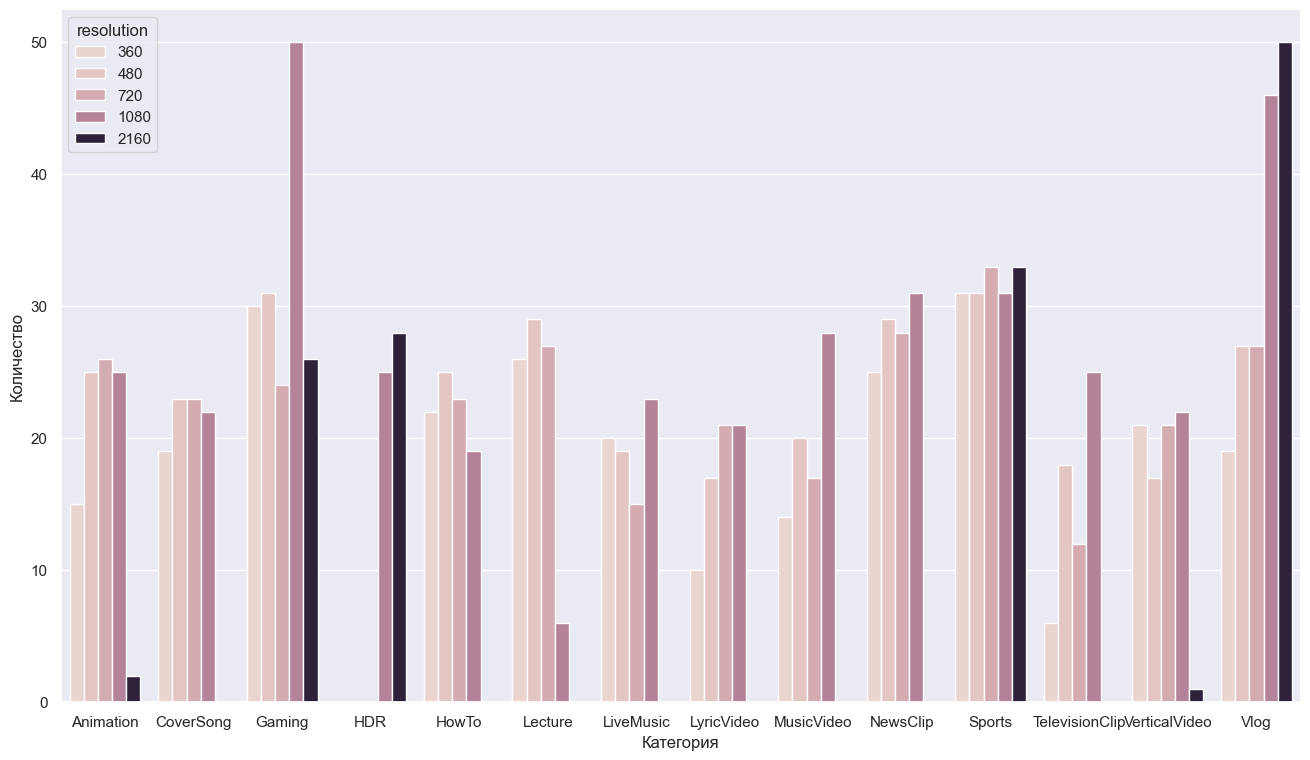

In [35]:
plot = sns.barplot(
    df.groupby(['category', 'resolution']).size().reset_index(),
    x='category',
    y=0,
    hue='resolution',
    # palette='light:purple'
)
plot.set_ylabel('Количество')
plot.set_xlabel('Категория')

/var/folders/4k/2vgv8hbs5sz71c1vn0474t2m0000gn/T/ipykernel_78161/1429781991.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


Text(0.5, 0, 'Разрешение')

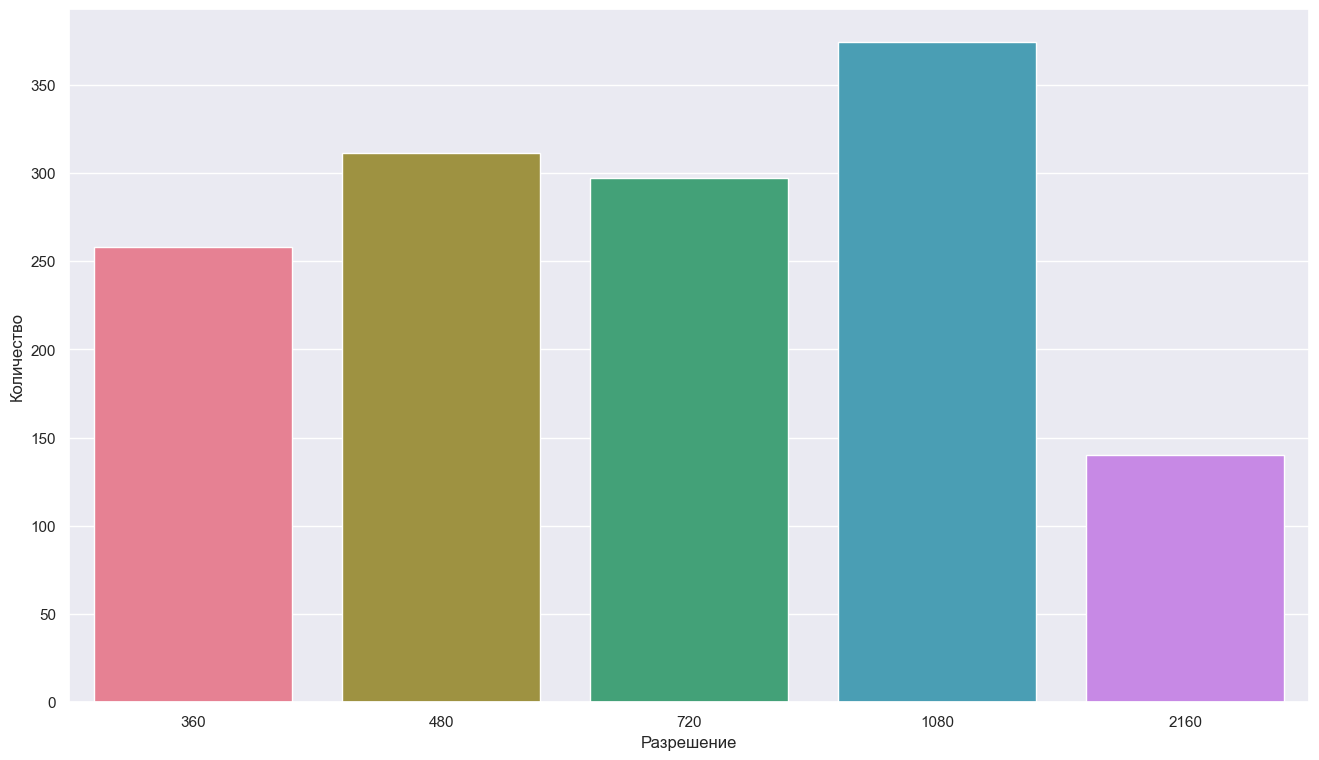

In [39]:
plot = sns.barplot(
    df.groupby(['resolution']).size().reset_index(),
    x='resolution',
    y=0,
    palette='husl'
)
plot.set_ylabel('Количество')
plot.set_xlabel('Разрешение')

/var/folders/4k/2vgv8hbs5sz71c1vn0474t2m0000gn/T/ipykernel_78161/494759709.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


Text(0.5, 0, 'Категория')

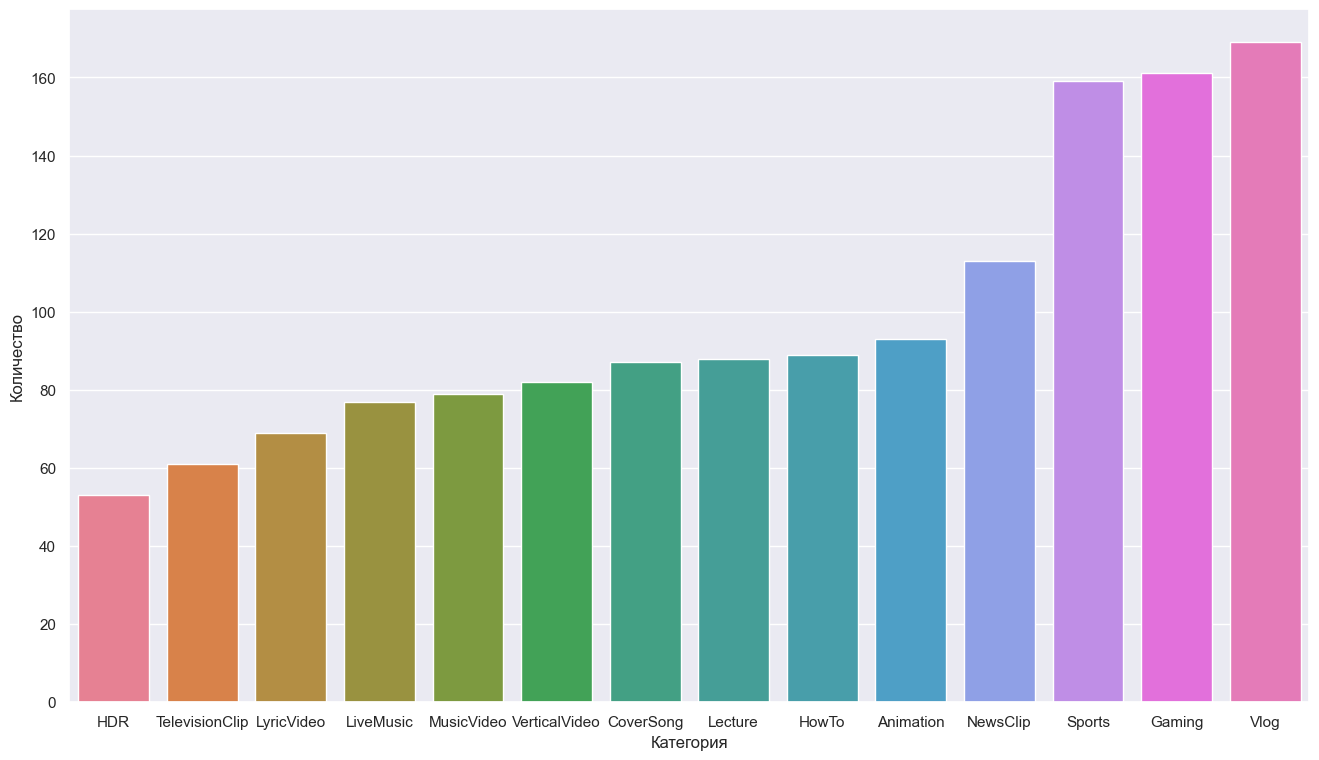

In [43]:
plot = sns.barplot(
    df.groupby(['category']).size().reset_index().sort_values(0),
    x='category',
    y=0,
    palette='husl'
)
plot.set_ylabel('Количество')
plot.set_xlabel('Категория')

In [3]:
import boto3
from botocore.config import Config
import os

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net/',
    aws_access_key_id=os.getenv('S3_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('S3_SECRET_ACCESS_KEY'),
    config=Config(max_pool_connections=100)
)

In [4]:
import logging
from typing import Iterator

def iter_over_bucket(client, bucket) -> Iterator[str]:
    args = {'Bucket': bucket, 'MaxKeys': 500}
    logging.info('list s3 objects')
    res = client.list_objects_v2(**args)
    while res['KeyCount'] > 0:
        logging.info(f'got {res["KeyCount"]} objects')
        for content in res['Contents']:
            yield content['Key']

        token_args = {}
        if next_token := res.get('NextContinuationToken'):
            token_args['ContinuationToken'] = next_token
            res = client.list_objects_v2(**args, **token_args)
        else:
            break

In [68]:
from tqdm import tqdm
features_bucket = 'tnn-feature-datasets'

full_feature_df = []
for path in tqdm(iter_over_bucket(s3_client, features_bucket)):
    csv_data = s3_client.get_object(Bucket=features_bucket, Key=path)['Body']
    feature_df = pd.read_csv(csv_data, sep='|')
    feature_df['path'] = path
    full_feature_df.append(feature_df)

full_feature_df = pd.concat(full_feature_df)
full_feature_df.info()

0it [00:00, ?it/s]

980it [01:59,  8.17it/s]


<class 'pandas.core.frame.DataFrame'>
Index: 583488 entries, 0 to 598
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   width                  583488 non-null  int64  
 1   height                 583488 non-null  int64  
 2   format                 583488 non-null  object 
 3   key_frame              583488 non-null  int64  
 4   time                   583488 non-null  float64
 5   pts                    583488 non-null  int64  
 6   dts                    583488 non-null  int64  
 7   CTI_std                583488 non-null  float64
 8   SI_std                 583488 non-null  float64
 9   TI_std                 582508 non-null  float64
 10  CTI_mean               583488 non-null  float64
 11  SI_mean                583488 non-null  float64
 12  TI_mean                582508 non-null  float64
 13  GLCM_correlation_mean  583488 non-null  float64
 14  GLCM_contrast_mean     583488 non-null  floa

In [70]:
full_feature_df.to_csv('features.csv')

In [71]:
full_feature_df.head()

,width,height,format,key_frame,time,pts,dts,CTI_std,SI_std,TI_std,...,GLCM_homogeneity_mean,GLCM_correlation_std,GLCM_contrast_std,GLCM_energy_std,GLCM_homogeneity_std,FSI13_mean,CI_U_mean,CI_V_mean,FHV13,path
0,1920,1080,yuv420p,1,0.00,0,0,60.721709,42.276787,NaN,...,0.874942,0.001785,13.147321,0.001079,0.021021,74.8750,127.578344,191.367516,18.166667,Animation/1080P/Animation_1080P-05f8.mkv.csv
1,1920,1080,yuv420p,1,0.04,40000,40000,60.752072,43.629593,60.835887,...,0.877909,0.001910,14.082974,0.001086,0.020844,74.6875,127.623374,191.435061,18.114583,Animation/1080P/Animation_1080P-05f8.mkv.csv
2,1920,1080,yuv420p,1,0.08,80000,80000,60.734796,42.469227,60.472099,...,0.879115,0.001818,13.398684,0.001187,0.021489,74.8125,127.663637,191.495455,18.166667,Animation/1080P/Animation_1080P-05f8.mkv.csv
3,1920,1080,yuv420p,1,0.12,120000,120000,60.736063,43.536686,58.674833,...,0.877522,0.001892,13.939902,0.001091,0.021000,74.2500,127.726554,191.589832,17.968750,Animation/1080P/Animation_1080P-05f8.mkv.csv
4,1920,1080,yuv420p,1,0.16,160000,160000,60.722993,42.369629,60.881488,...,0.875207,0.001805,13.295951,0.001074,0.021119,74.7500,127.766877,191.650316,18.135417,Animation/1080P/Animation_1080P-05f8.mkv.csv


In [57]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
qualitys_bucket = 'tnn-video-quality'

def get_df(path: str):
    csv_data = s3_client.get_object(Bucket=qualitys_bucket, Key=path)['Body']
    quality_df = pd.read_csv(csv_data, sep=',')
    quality_df['path'] = path
    return quality_df

full_quality_df = []
all_paths = list(iter_over_bucket(s3_client, qualitys_bucket))
with ThreadPoolExecutor(max_workers=15) as pool:
    for quality_df in tqdm(pool.map(get_df, all_paths), total=len(all_paths)):
        full_quality_df.append(quality_df)

full_quality_df = pd.concat(full_quality_df)
full_quality_df.info()

100%|██████████| 30000/30000 [07:08<00:00, 70.02it/s] 


<class 'pandas.core.frame.DataFrame'>
Index: 18289725 entries, 0 to 598
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Frame                     int64  
 1   integer_motion2           float64
 2   integer_motion            float64
 3   integer_vif_scale0_egl_1  float64
 4   integer_vif_scale1_egl_1  float64
 5   integer_vif_scale2_egl_1  float64
 6   integer_vif_scale3_egl_1  float64
 7   integer_adm2_egl_1        float64
 8   integer_adm_scale0_egl_1  float64
 9   integer_adm_scale1_egl_1  float64
 10  integer_adm_scale2_egl_1  float64
 11  integer_adm_scale3_egl_1  float64
 12  vmaf_neg                  float64
 13  Unnamed: 13               float64
 14  path                      object 
dtypes: float64(13), int64(1), object(1)
memory usage: 2.2+ GB


In [58]:
full_quality_df = full_quality_df.drop(columns=['Unnamed: 13'], errors='ignore')
full_quality_df.to_csv('qualities.csv')

In [9]:
full_feature_df.sample(10)

NameError: name 'full_feature_df' is not defined

In [96]:
def extract_name(item):
    return item.rpartition('/')[-1].partition('.')[0]

full_feature_df['name'] =  full_feature_df.path.map(extract_name)

In [ ]:
big_features = full_feature_df.groupby('name').agg({
    'width': 'min',
    'height': 'min',
    'format': 'first',
    'CTI_std': ['min', 'mean', 'median', 'max', 'std'],
    'SI_std': ['min', 'mean', 'median', 'max', 'std'],
    'TI_std': ['min', 'mean', 'median', 'max', 'std'],
    'CTI_mean': ['min', 'mean', 'median', 'max', 'std'],
    'SI_mean': ['min', 'mean', 'median', 'max', 'std'],
    'TI_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_correlation_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_contrast_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_energy_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_homogeneity_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_correlation_std': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_contrast_std': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_energy_std': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_homogeneity_std': ['min', 'mean', 'median', 'max', 'std'],
    'FSI13_mean': ['min', 'mean', 'median', 'max', 'std'],
    'CI_U_mean': ['min', 'mean', 'median', 'max', 'std'],
    'CI_V_mean': ['min', 'mean', 'median', 'max', 'std'],
    'FHV13': ['min', 'mean', 'median', 'max', 'std']
}).reset_index()

In [137]:
big_features.columns = big_features.columns.map('_'.join)
big_features

,name_,width_min,height_min,format_first,CTI_std_min,CTI_std_mean,CTI_std_median,CTI_std_max,CTI_std_std,SI_std_min,...,CI_V_mean_min,CI_V_mean_mean,CI_V_mean_median,CI_V_mean_max,CI_V_mean_std,FHV13_min,FHV13_mean,FHV13_median,FHV13_max,FHV13_std
0,Animation_1080P-05f8,1920,1080,yuv420p,44.182550,52.156226,52.109668,60.752072,2.904819,14.939627,...,80.000000,151.482895,123.352363,207.739868,49.339612,1.000000,22.533888,18.947917,36.895833,11.117238
1,Animation_1080P-0c4f,1920,1080,yuv420p,42.300637,45.980305,46.295275,51.364939,2.045704,80.178947,...,243.506310,258.492611,258.702112,271.874362,5.855529,15.468750,21.280859,22.937500,26.333333,3.319351
2,Animation_1080P-18f5,1920,1080,yuv420p,55.678482,60.176203,60.409364,66.221454,2.808085,64.997353,...,183.764036,217.636896,223.705146,230.810561,13.477754,26.145833,28.073664,28.229167,30.291667,0.995820
3,Animation_1080P-209f,1920,1080,yuv420p,41.429365,43.924084,42.412440,48.773801,2.854323,63.522049,...,234.185509,241.594533,234.606746,262.734905,11.253415,25.208333,26.286500,26.541667,26.937500,0.559128
4,Animation_1080P-21dd,1920,1080,yuv420p,53.492048,54.621218,54.238353,56.642177,0.974844,41.466827,...,87.924982,92.114836,91.311481,98.091593,3.162987,22.437500,23.858429,23.895833,26.375000,0.628671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,Vlog_720P-3e9c,1280,720,yuv420p,59.945031,63.419143,63.905179,65.593744,1.471084,51.124294,...,218.031717,223.295938,222.454109,228.691708,2.728591,23.270833,25.090180,24.854167,27.229167,0.896256
976,Vlog_720P-4e3d,1280,720,yuv420p,42.233801,53.955423,54.909413,62.063753,4.164083,39.386581,...,157.430324,176.259133,176.564370,217.024146,9.194265,25.916667,29.617326,29.229167,35.145833,1.453339
977,Vlog_720P-5364,1280,720,yuv420p,20.590320,39.452944,41.478989,73.587980,9.846750,4.397942,...,85.837488,155.677365,173.278845,261.149613,47.577228,20.375000,37.351736,36.729167,52.208333,4.608039
978,Vlog_720P-60f8,1280,720,yuv420p,35.030290,41.984969,40.648420,50.228325,3.578561,16.094381,...,147.860844,180.740116,180.459881,237.639770,9.958203,28.541667,32.693637,33.041667,39.500000,1.798026


Есть разница между CSV данными и тем что хранится на S3 в Google

In [100]:
len(set(df['vid'].unique()) - set(full_feature_df['name'].unique()))

400

In [138]:
big_features.to_csv('big_features.csv')

In [59]:
full_quality_df.sample(10)

,Frame,integer_motion2,integer_motion,integer_vif_scale0_egl_1,integer_vif_scale1_egl_1,integer_vif_scale2_egl_1,integer_vif_scale3_egl_1,integer_adm2_egl_1,integer_adm_scale0_egl_1,integer_adm_scale1_egl_1,integer_adm_scale2_egl_1,integer_adm_scale3_egl_1,vmaf_neg,path
57,57,0.310448,0.401286,0.508429,0.854123,0.920948,0.951645,0.961029,0.947440,0.946158,0.963319,0.975429,82.331209,Sports/1080P/Sports_1080P-19d8_qp_33.mkv.vmaf.csv
181,181,3.257037,12.325736,0.565083,0.895033,0.945237,0.967560,0.971895,0.953579,0.950498,0.974771,0.982749,90.358181,NewsClip/1080P/NewsClip_1080P-67dc_qp_31.mkv.v...
139,139,12.731443,13.159945,0.320746,0.644157,0.736903,0.792972,0.862621,0.896975,0.814430,0.847738,0.889089,59.648281,Sports/2160P/Sports_2160P-3d85_qp_38.mkv.vmaf.csv
89,89,6.734498,6.734498,0.445875,0.819099,0.901957,0.942173,0.902642,0.885592,0.844318,0.901707,0.943691,76.185276,Animation/480P/Animation_480P-073c_qp_34.mkv.v...
165,165,14.426362,14.426362,0.863525,0.990371,0.995762,0.997660,0.991792,0.985504,0.980475,0.989332,0.995942,100.000000,NewsClip/480P/NewsClip_480P-5a3b_crf_18.mkv.vm...
537,537,2.058795,2.354449,0.228082,0.791152,0.863450,0.907461,0.935939,0.947351,0.891620,0.917904,0.961800,74.745983,Lecture/720P/Lecture_720P-4c87_qp_39.mkv.vmaf.csv
105,105,14.626052,14.626052,0.796071,0.943651,0.967814,0.979746,0.979721,0.984646,0.967676,0.972009,0.986111,100.000000,VerticalVideo/480P/VerticalVideo_480P-2fa4_qp_...
42,42,5.704131,5.736218,0.546779,0.861484,0.915753,0.945108,0.944431,0.949822,0.942847,0.945169,0.941041,84.397552,Gaming/720P/Gaming_720P-0fdb_qp_29.mkv.vmaf.csv
277,277,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,97.428043,Gaming/480P/Gaming_480P-6548_crf_30.mkv.vmaf.csv
205,205,0.005125,0.005125,0.799488,0.987095,0.993183,0.995594,0.990641,0.984787,0.987634,0.991765,0.993711,94.670155,Vlog/720P/Vlog_720P-3e9c_crf_25.mkv.vmaf.csv


In [60]:
def extract_name(item):
    return item.rpartition('/')[-1].partition('.')[0]

full_quality_df['name'] = full_quality_df['path'].map(extract_name)

In [15]:
aggregated_quality = full_quality_df.groupby('name').agg({
    'vmaf_neg': ['min','mean','median', 'max'],
})

In [16]:
aggregated_quality.columns = aggregated_quality.columns.map('_'.join)
aggregated_quality

,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
name,,,,
Animation_1080P-05f8_crf_22,92.363295,96.517415,95.487515,100.000000
Animation_1080P-05f8_crf_28,85.563648,92.894396,93.169653,99.938332
Animation_1080P-05f8_qp_28,87.808972,94.074711,92.575532,100.000000
Animation_1080P-0c4f_crf_21,92.984327,95.494797,95.380633,100.000000
Animation_1080P-0c4f_crf_23,91.742563,94.918434,94.843951,100.000000
...,...,...,...,...
Lecture_360P-27db_qp_40,66.110624,72.332504,71.586964,83.956261
Lecture_360P-311d_qp_34,68.209734,85.219207,84.101906,96.320918
Lecture_360P-4bb4_qp_32,83.132077,85.663009,85.884668,90.402968


In [123]:
aggregated_quality.reset_index()

,name,distorted_format_first,Y_mssim_min,Y_mssim_mean,Y_mssim_median,Y_mssim_max
0,Animation_1080P-05f8_crf_17,yuv420p,1.000000,1.000000,1.000000,1.0
1,Animation_1080P-05f8_crf_18,yuv420p,1.000000,1.000000,1.000000,1.0
2,Animation_1080P-05f8_crf_19,yuv420p,1.000000,1.000000,1.000000,1.0
3,Animation_1080P-05f8_crf_20,yuv420p,1.000000,1.000000,1.000000,1.0
4,Animation_1080P-05f8_crf_21,yuv420p,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...
29945,Vlog_720P-6d56_qp_36,yuv420p,0.999998,0.999999,1.000000,1.0
29946,Vlog_720P-6d56_qp_37,yuv420p,0.999998,0.999999,1.000000,1.0
29947,Vlog_720P-6d56_qp_38,yuv420p,0.999997,0.999999,0.999999,1.0
29948,Vlog_720P-6d56_qp_39,yuv420p,0.999997,0.999999,0.999999,1.0


In [17]:
aggregated_quality.loc['Vlog_1080P-010b_qp_40']

KeyError: 'Vlog_1080P-010b_qp_40'

In [17]:
def parse_name(item):
    name = item['path'].rpartition('/')[-1].partition('.')[0]
    source_name, parameter, value = name.rsplit('_', 2)
    value = int(value)
    return {'source_name': source_name, 'parameter': parameter, 'value': value}

In [ ]:

really_full_quality_df = pd.concat([full_quality_df, full_quality_df.apply(parse_name, axis=1, result_type='expand')], axis=1)

In [62]:
really_full_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18289725 entries, 0 to 598
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Frame                     int64  
 1   integer_motion2           float64
 2   integer_motion            float64
 3   integer_vif_scale0_egl_1  float64
 4   integer_vif_scale1_egl_1  float64
 5   integer_vif_scale2_egl_1  float64
 6   integer_vif_scale3_egl_1  float64
 7   integer_adm2_egl_1        float64
 8   integer_adm_scale0_egl_1  float64
 9   integer_adm_scale1_egl_1  float64
 10  integer_adm_scale2_egl_1  float64
 11  integer_adm_scale3_egl_1  float64
 12  vmaf_neg                  float64
 13  path                      object 
 14  name                      object 
 15  source_name               object 
 16  parameter                 object 
 17  value                     int64  
dtypes: float64(12), int64(2), object(4)
memory usage: 2.6+ GB


In [63]:
really_full_quality_df.to_csv('qualities.csv')

In [35]:
really_full_quality_df = qualities_df

In [36]:
aggregated_quality = really_full_quality_df.groupby(['source_name', 'parameter', 'value']).agg({
    'vmaf_neg': ['min','mean','median', 'max'],
})

In [37]:
aggregated_quality.columns = aggregated_quality.columns.map('_'.join)
aggregated_quality

vmaf_neg_min  vmaf_neg_mean  \
source_name          parameter value                                
Animation_1080P-05f8 crf       17        94.140357      97.627268   
                               18        93.809997      97.482780   
                               19        93.572339      97.321157   
                               20        93.281218      97.130756   
                               21        92.991453      96.902823   
...                                            ...            ...   
Vlog_720P-6d56       qp        36        61.691553      81.794359   
                               37        56.549579      78.906290   
                               38        52.161389      75.671001   
                               39        46.798782      72.508412   
                               40        43.241387      68.939786   

                                      vmaf_neg_median  vmaf_neg_max  
source_name          parameter value                                 
Animation_1080P-05f8 crf       17           97.245841         100.0  
                               18           96.818206         100.0  
                               19           96.266597         100.0  
                               20           95.895994         100.0  
                               21           95.747015         100.0  
...                                               ...           ...  
Vlog_720P-6d56       qp        36           79.423987         100.0  
                               37           76.757324         100.0  
                               38           73.516446         100.0  
                               39           70.184381         100.0  
                               40           66.194032         100.0  

[30000 rows x 4 columns]

In [38]:
aggregated_quality = aggregated_quality.reset_index()
aggregated_quality

,source_name,parameter,value,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
0,Animation_1080P-05f8,crf,17,94.140357,97.627268,97.245841,100.0
1,Animation_1080P-05f8,crf,18,93.809997,97.482780,96.818206,100.0
2,Animation_1080P-05f8,crf,19,93.572339,97.321157,96.266597,100.0
3,Animation_1080P-05f8,crf,20,93.281218,97.130756,95.895994,100.0
4,Animation_1080P-05f8,crf,21,92.991453,96.902823,95.747015,100.0
...,...,...,...,...,...,...,...
29995,Vlog_720P-6d56,qp,36,61.691553,81.794359,79.423987,100.0
29996,Vlog_720P-6d56,qp,37,56.549579,78.906290,76.757324,100.0
29997,Vlog_720P-6d56,qp,38,52.161389,75.671001,73.516446,100.0
29998,Vlog_720P-6d56,qp,39,46.798782,72.508412,70.184381,100.0


<Axes: ylabel='vmaf_neg_min'>

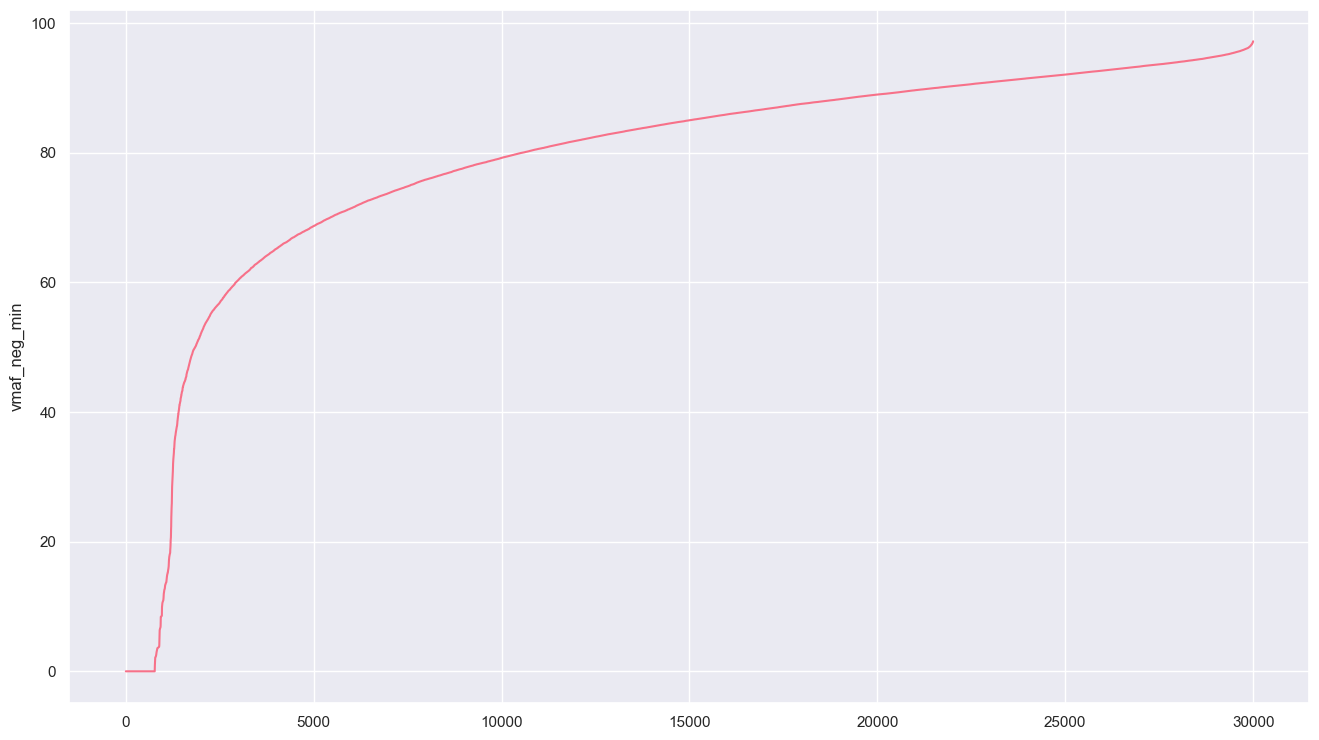

In [68]:
sns.lineplot(aggregated_quality['vmaf_neg_min'].sort_values().reset_index()['vmaf_neg_min'])

In [135]:
big_features.columns

Index(['name_', 'width_min', 'height_min', 'format_first', 'CTI_std_min',
       'CTI_std_mean', 'CTI_std_median', 'CTI_std_max', 'SI_std_min',
       'SI_std_mean', 'SI_std_median', 'SI_std_max', 'TI_std_min',
       'TI_std_mean', 'TI_std_median', 'TI_std_max', 'CTI_mean_min',
       'CTI_mean_mean', 'CTI_mean_median', 'CTI_mean_max', 'SI_mean_min',
       'SI_mean_mean', 'SI_mean_median', 'SI_mean_max', 'TI_mean_min',
       'TI_mean_mean', 'TI_mean_median', 'TI_mean_max',
       'GLCM_correlation_mean_min', 'GLCM_correlation_mean_mean',
       'GLCM_correlation_mean_median', 'GLCM_correlation_mean_max',
       'GLCM_contrast_mean_min', 'GLCM_contrast_mean_mean',
       'GLCM_contrast_mean_median', 'GLCM_contrast_mean_max',
       'GLCM_energy_mean_min', 'GLCM_energy_mean_mean',
       'GLCM_energy_mean_median', 'GLCM_energy_mean_max',
       'GLCM_homogeneity_mean_min', 'GLCM_homogeneity_mean_mean',
       'GLCM_homogeneity_mean_median', 'GLCM_homogeneity_mean_max',
       'GLCM_co

/Users/tiunovnn/git/video-compression-model/.venv/lib/python3.12/site-packages/numpy/lib/_scimath_impl.py:383: RuntimeWarning: divide by zero encountered in divide
  return nx.log(x)/nx.log(n)


Text(-100, 10, 'Оптимальность')

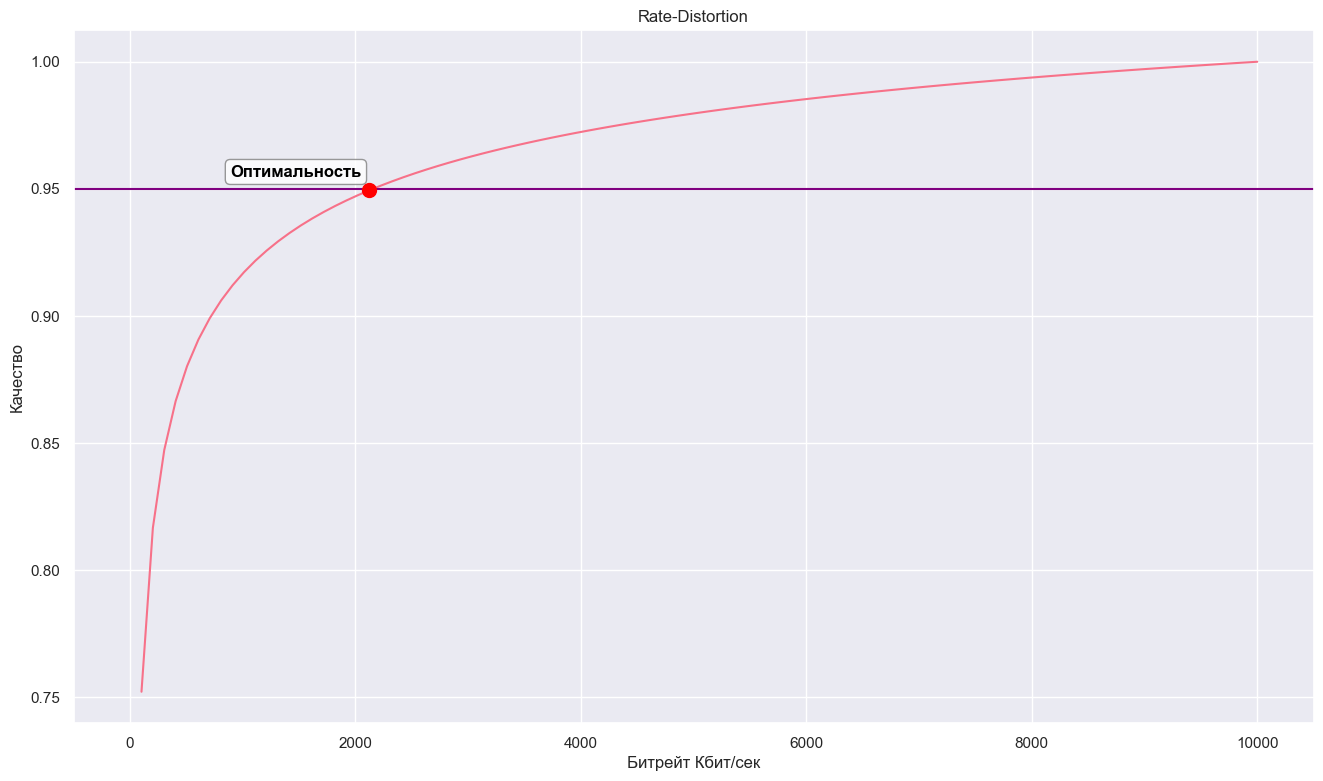

In [ ]:
import numpy as np
head = 10000
data = (np.emath.logn(np.linspace(1, head, 100), 1/head) + 2) / 4 + 0.75
x = np.linspace(1, head, 100)
plot = sns.lineplot(y=data, x=x)
plot.set_title('Rate-Distortion')
plot.set_xlabel('Битрейт Кбит/сек')
plot.set_ylabel('Качество')
plot.axline((0, 0.95), slope=0, color='purple')

intersection_idx = np.argmin(np.abs(data - 0.95))
intersection_x = x[intersection_idx]
intersection_y = data[intersection_idx]

# Добавляем точку на месте пересечения
plot.scatter(intersection_x, intersection_y, color='red', s=100, zorder=5)

# Добавляем текст "Оптимальность" к точке
plot.annotate("Оптимальность",
             (intersection_x, intersection_y),
             xytext=(-100, 10),  # смещение текста относительно точки
             textcoords='offset points',
             fontsize=12,
             color='black',
             weight='bold',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


In [ ]:
vlog_df = aggregated_quality[aggregated_quality.source_name == 'Animation_1080P-0c4f']

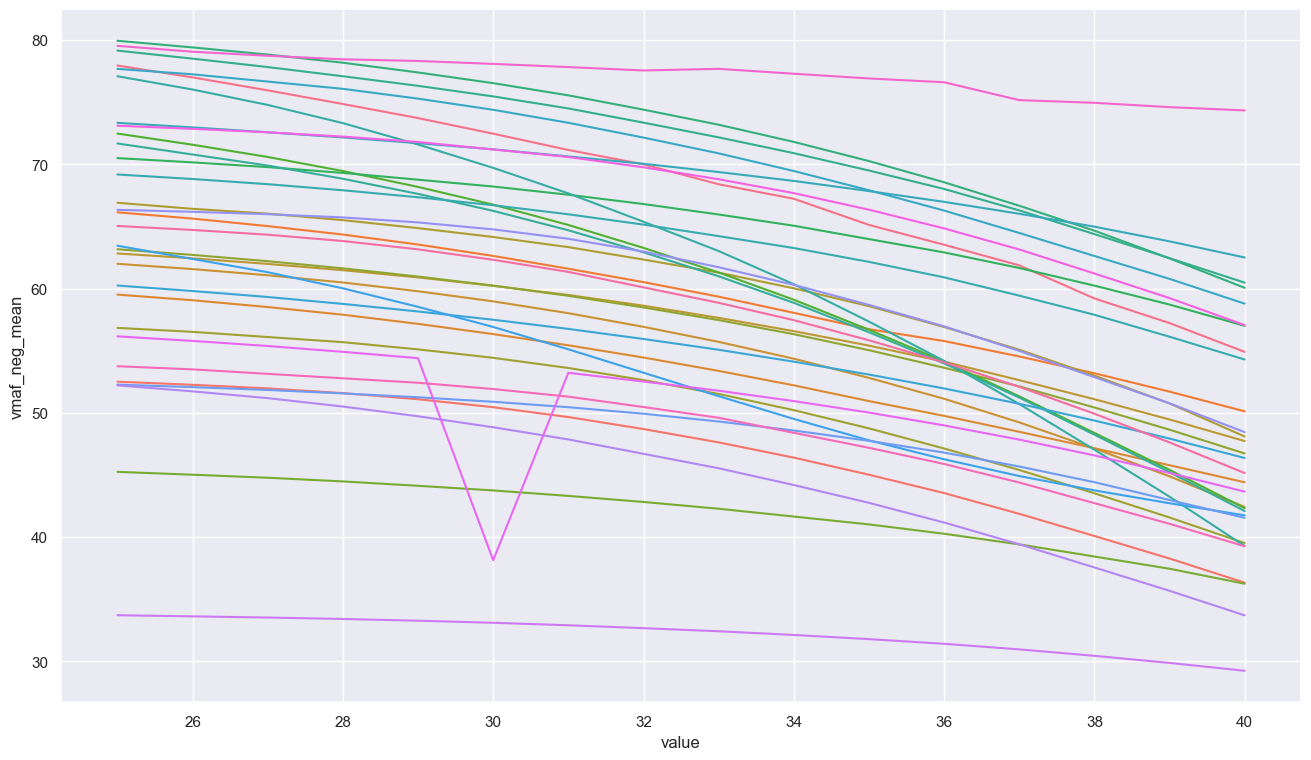

In [78]:
plt.figure(figsize=(16,9))
plot = sns.lineplot(aggregated_quality[(aggregated_quality['parameter'] == 'qp') & aggregated_quality['source_name'].isin(wrong_sources)], x='value', y='vmaf_neg_mean', hue='source_name')
plot.ticklabel_format(axis='y', style='plain')
plt.legend([],[], frameon=False)

In [77]:
wrong_sources = aggregated_quality[(aggregated_quality['parameter'] == 'qp') & (aggregated_quality['value'] < 26) & (aggregated_quality['vmaf_neg_mean'] < 80)]['source_name'].unique()

In [81]:
aggregated_quality[(aggregated_quality['parameter'] == 'qp') & (aggregated_quality['value'] < 26) & (aggregated_quality['vmaf_neg_mean'] > 90)]

,source_name,parameter,value,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
9,Animation_1080P-05f8,qp,25,90.485480,95.702586,95.060928,100.000000
31,Animation_1080P-0c4f,qp,25,92.493077,94.312309,93.802343,100.000000
79,Animation_1080P-209f,qp,25,94.089540,95.402239,95.355632,99.313822
109,Animation_1080P-21dd,qp,25,42.574393,99.428051,100.000000,100.000000
139,Animation_1080P-2fbe,qp,25,87.048437,95.556841,96.617345,100.000000
...,...,...,...,...,...,...,...
29864,Vlog_720P-3e9c,qp,25,91.893792,93.485628,93.286395,94.998867
29894,Vlog_720P-4e3d,qp,25,92.568287,97.181160,100.000000,100.000000
29924,Vlog_720P-5364,qp,25,77.876821,92.039286,91.675607,100.000000
29954,Vlog_720P-60f8,qp,25,93.099065,99.489412,100.000000,100.000000


In [3]:
import shutil

executable_name = 'ffprobe'
possible_bin_dirs = [
    f'./{executable_name}',
    executable_name,
]

for bin_ in possible_bin_dirs:
    if resolved_binary := shutil.which(bin_):
        ffprobe_bin = resolved_binary
        break
ffprobe_bin

'./ffprobe'

In [16]:
import subprocess
import json

def analyze_file(url):
    input_params = [
        '-seekable', '1',
        '-reconnect_delay_max', '300',
        '-multiple_requests', '1',
        '-reconnect_on_http_error', '429,5xx',
        '-reconnect_on_network_error', '1',
        '-i', url,
    ]
    analyze_params = [
        '-show_streams',
        '-show_format',
        '-print_format', 'json'
    ]
    global_params = [
        '-hide_banner',
        '-loglevel', 'error',
    ]

    # Run the command
    try:
        result = subprocess.run(
            [
                ffprobe_bin,
                *input_params,
                *analyze_params,
                *global_params
            ], check=True, capture_output=True, text=True
        )
    except subprocess.CalledProcessError as e:
        logging.error(f"Error analyze video: {e.stderr}")
        raise RuntimeError(str(e.stderr)) from e
    data = json.loads(result.stdout)
    try:
        duration = data['streams'][0]['duration']
    except KeyError:
        duration = data['format']['duration']
    try:
        bitrate = data['streams'][0]['bit_rate']
    except KeyError:
        bitrate = data['format']['bit_rate']
    return {
        'duration': duration,
        'bit_rate': bitrate,
        'size': data['format']['size']
    }

In [15]:
import subprocess
import json
import logging

def analyze_video_packets(url: str) -> list[dict]:
    input_params = [
        '-seekable', '1',
        '-reconnect_delay_max', '300',
        '-multiple_requests', '1',
        '-reconnect_on_http_error', '429,5xx',
        '-reconnect_on_network_error', '1',
        '-i', url,
    ]
    analyze_params = [
        '-show_packets',
        '-print_format', 'json=compact=1',
        '-show_entries', 'packet=pts,pts_time,duration,duration_time,flags,stream_index,size,pos',
    ]
    global_params = [
        '-hide_banner',
        '-loglevel', 'error',
    ]

    # Run the command
    try:
        result = subprocess.run(
            [
                ffprobe_bin,
                *input_params,
                *analyze_params,
                *global_params
            ], check=True, capture_output=True, text=True
        )
    except subprocess.CalledProcessError as e:
        logging.error(f"Error analyze video: {e.stderr}")
        raise RuntimeError(str(e.stderr)) from e
    data = json.loads(result.stdout)
    return data['packets']

In [92]:
analyze_file('/Users/tiunovnn/Downloads/Gaming_1080P-13e3_qp_25.mkv')

{'duration': '20.003316', 'bit_rate': '21972714', 'size': '54959976'}

In [10]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
encoded_bucket = 'tnn-video-encoded'

full_feature_df = []
paths = list(iter_over_bucket(s3_client, encoded_bucket))

def analyze_encoded_video(path: str):
    presigned_url = s3_client.generate_presigned_url(
        'get_object',
        Params={'Bucket': encoded_bucket, 'Key': path},
        ExpiresIn=3600 * 24,
    )
    result = analyze_file(presigned_url)
    result.update(parse_name({'path': path}))
    return result

items = []
with ThreadPoolExecutor() as pool:
    for result in tqdm(pool.map(analyze_encoded_video, paths), total=len(paths)):
        items.append(result)

analyzed_encoded_df = pd.DataFrame(items)
analyzed_encoded_df

100%|██████████| 30053/30053 [02:52<00:00, 174.47it/s]


,duration,bit_rate,size,source_name,parameter,value
0,19.960000,16266563,40593806,Animation_1080P-05f8,crf,17
1,19.960000,14138555,35284346,Animation_1080P-05f8,crf,18
2,19.960000,12214888,30484729,Animation_1080P-05f8,crf,19
3,19.960000,10485608,26170157,Animation_1080P-05f8,crf,20
4,19.960000,8997804,22458050,Animation_1080P-05f8,crf,21
...,...,...,...,...,...,...
30048,19.986633,865778,2173102,Vlog_720P-6d56,qp,36
30049,19.986633,722064,1814043,Vlog_720P-6d56,qp,37
30050,19.986633,607407,1527592,Vlog_720P-6d56,qp,38
30051,19.986633,514341,1295082,Vlog_720P-6d56,qp,39


In [17]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
encoded_bucket = 'tnn-video-dataset'

full_feature_df = []
paths = list(iter_over_bucket(s3_client, encoded_bucket))

def analyze_source_video(path: str):
    presigned_url = s3_client.generate_presigned_url(
        'get_object',
        Params={'Bucket': encoded_bucket, 'Key': path},
        ExpiresIn=3600 * 24,
    )
    result = analyze_file(presigned_url)
    result['source_name'] = path.rpartition('/')[-1].partition('.')[0]
    return result

items = []
with ThreadPoolExecutor() as pool:
    for result in tqdm(pool.map(analyze_source_video, paths), total=len(paths)):
        items.append(result)

analyzed_source_df = pd.DataFrame(items)
analyzed_source_df

100%|██████████| 1018/1018 [00:05<00:00, 189.74it/s]


,duration,bit_rate,size,source_name
0,19.960000,622090913,1552116828,Animation_1080P-05f8
1,19.978291,596610691,1489907750,Animation_1080P-0c4f
2,19.986634,745763253,1863162150,Animation_1080P-18f5
3,20.000000,622090908,1555227271,Animation_1080P-209f
4,19.978291,596610695,1489907762,Animation_1080P-21dd
...,...,...,...,...
1013,19.960000,276490705,689844310,Vlog_720P-3e9c
1014,20.000000,331788798,829471996,Vlog_720P-4e3d
1015,20.000000,331788796,829471992,Vlog_720P-5364
1016,19.960000,276490710,689844322,Vlog_720P-60f8


In [25]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
encoded_bucket = 'tnn-video-encoded'

paths = list(iter_over_bucket(s3_client, encoded_bucket))

def analyze_encoded_video_packets(path: str):
    presigned_url = s3_client.generate_presigned_url(
        'get_object',
        Params={'Bucket': encoded_bucket, 'Key': path},
        ExpiresIn=3600 * 24,
    )
    result = analyze_video_packets(presigned_url)
    df = pd.DataFrame(result)
    for key, value in parse_name({'path': path}).items():
        df[key] = value
    return df

items = []
with ThreadPoolExecutor() as pool:
    for result in tqdm(pool.map(analyze_encoded_video_packets, paths), total=len(paths)):
        items.append(result)

analyzed_encoded_packets_df = pd.concat(items)
analyzed_encoded_packets_df

100%|██████████| 30053/30053 [08:26<00:00, 59.29it/s] 


,stream_index,pts,pts_time,duration,duration_time,size,pos,flags,source_name,parameter,value
0,0,0,0.000000,512,0.040000,101004,44,K_,Animation_1080P-05f8,crf,17
1,0,3584,0.280000,512,0.040000,70443,101048,__,Animation_1080P-05f8,crf,17
2,0,2048,0.160000,512,0.040000,19107,171491,__,Animation_1080P-05f8,crf,17
3,0,512,0.040000,512,0.040000,17486,190598,__,Animation_1080P-05f8,crf,17
4,0,1024,0.080000,512,0.040000,14665,208084,__,Animation_1080P-05f8,crf,17
...,...,...,...,...,...,...,...,...,...,...,...
594,0,592592,19.753067,1001,0.033367,1073,1088476,__,Vlog_720P-6d56,qp,40
595,0,598598,19.953267,1001,0.033367,4345,1089549,__,Vlog_720P-6d56,qp,40
596,0,596596,19.886533,1001,0.033367,2750,1093894,__,Vlog_720P-6d56,qp,40
597,0,595595,19.853167,1001,0.033367,1001,1096644,__,Vlog_720P-6d56,qp,40


In [24]:
bitrate_df = analyzed_encoded_df.merge(analyzed_source_df, left_on='source_name', right_on='source_name', suffixes=['_encoded', '_source'], validate='m:1')

In [25]:
bitrate_df.to_csv('bitrate.csv.gz', index=False, compression='gzip')

In [27]:
s3_client.upload_file('bitrate.csv.gz', Bucket='tnn-datasets', Key='bitrate.csv.gz')

In [28]:
really_full_quality_df = pd.read_csv('https://storage.yandexcloud.net/tnn-datasets/qualities.csv.gz')
really_full_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18289725 entries, 0 to 18289724
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   Frame                     int64  
 2   integer_motion2           float64
 3   integer_motion            float64
 4   integer_vif_scale0_egl_1  float64
 5   integer_vif_scale1_egl_1  float64
 6   integer_vif_scale2_egl_1  float64
 7   integer_vif_scale3_egl_1  float64
 8   integer_adm2_egl_1        float64
 9   integer_adm_scale0_egl_1  float64
 10  integer_adm_scale1_egl_1  float64
 11  integer_adm_scale2_egl_1  float64
 12  integer_adm_scale3_egl_1  float64
 13  vmaf_neg                  float64
 14  path                      object 
 15  name                      object 
 16  source_name               object 
 17  parameter                 object 
 18  value                     int64  
dtypes: float64(12), int64(3), object(4)
memory usage: 2.6+ GB


In [39]:
quality_bitrate_df = aggregated_quality.merge(bitrate_df, how='inner', left_on=['source_name', 'parameter', 'value'], right_on=['source_name', 'parameter', 'value'])

In [40]:
quality_bitrate_df.sample(10)

,source_name,parameter,value,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max,duration_encoded,bit_rate_encoded,size_encoded,duration_source,bit_rate_source,size_source
22234,Sports_360P-50fd,qp,38,73.443622,83.937523,84.208799,98.903631,19.986633,947374,2377045,19.986634,94521952,236146958
23754,Sports_720P-3072,qp,31,87.869946,96.223035,96.455005,100.000000,19.986633,3923664,9812757,19.986634,331457326,828089533
25637,TelevisionClip_720P-5e93,crf,22,93.307552,95.252754,94.938157,100.000000,19.960000,1071045,2682066,19.960000,276490710,689844322
29723,Vlog_720P-155f,qp,32,83.164943,95.200738,95.585982,100.000000,19.986633,5467330,13669315,19.986634,331457333,828089552
27049,VerticalVideo_720P-1ada,qp,32,75.347785,81.485385,81.313187,93.195020,20.008030,1606315,4028273,20.008030,330550120,826707092
29298,Vlog_480P-535d,qp,27,90.978951,95.727120,94.976016,100.000000,19.986633,941872,2363121,19.986634,124304485,310553532
2071,CoverSong_1080P-033d,qp,38,53.122745,58.275096,57.819761,70.791986,20.000000,555927,1400082,20.000000,746509046,1866272615
17481,MusicVideo_720P-5c9c,qp,29,76.651212,85.695206,85.862188,100.000000,20.000000,7523579,18824880,20.000000,552981173,1382452934
18716,NewsClip_480P-15fa,qp,34,75.615909,85.145664,86.559773,97.220143,19.960000,446788,1124135,19.960000,92170694,229965882
21358,Sports_2160P-3d85,qp,25,90.877449,99.025028,100.000000,100.000000,19.986633,76287822,190605092,19.986634,2983014035,7452551219


In [36]:
quality_bitrate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source_name       30000 non-null  object 
 1   parameter         30000 non-null  object 
 2   value             30000 non-null  int64  
 3   vmaf_neg_min      30000 non-null  float64
 4   vmaf_neg_mean     30000 non-null  float64
 5   vmaf_neg_median   30000 non-null  float64
 6   vmaf_neg_max      30000 non-null  float64
 7   duration_encoded  30000 non-null  object 
 8   bit_rate_encoded  30000 non-null  object 
 9   size_encoded      30000 non-null  object 
 10  duration_source   30000 non-null  object 
 11  bit_rate_source   30000 non-null  object 
 12  size_source       30000 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 3.0+ MB


In [38]:
quality_bitrate_df = quality_bitrate_df.astype({
    'duration_encoded': 'float32',
    'bit_rate_encoded': 'int64',
    'size_encoded': 'int64',
    'duration_source': 'float32',
    'bit_rate_source': 'int64',
    'size_source': 'int64'
})

In [ ]:
def select_best_row(group):
    # Проверяем, есть ли строки с vmaf_neg_mean >= 95
    high_quality_rows = group[group['vmaf_neg_mean'] >= 95]

    if not high_quality_rows.empty:
        # Если есть, выбираем строку с минимальным битрейтом
        return high_quality_rows.loc[high_quality_rows['bit_rate_encoded'].idxmin()]
    else:
        # Иначе выбираем строку с максимальным битрейтом
        return group.loc[group['bit_rate_encoded'].idxmax()]

target_dataset_df = quality_bitrate_df.groupby('source_name').apply(select_best_row).reset_index(drop=True)

/var/tmp/ipykernel_724876/2566706187.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_dataset_df = quality_bitrate_df.groupby('source_name').apply(select_best_row).reset_index(drop=True)


In [41]:
target_dataset_df.to_csv('target_dataset_df.csv.gz', index=False, compression='gzip')

In [6]:
target_dataset_df = pd.read_csv('target_dataset_df.csv.gz')
target_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source_name       1018 non-null   object 
 1   parameter         1018 non-null   object 
 2   value             1018 non-null   int64  
 3   vmaf_neg_min      1018 non-null   float64
 4   vmaf_neg_mean     1018 non-null   float64
 5   vmaf_neg_median   1018 non-null   float64
 6   vmaf_neg_max      1018 non-null   float64
 7   duration_encoded  1018 non-null   float64
 8   bit_rate_encoded  1018 non-null   int64  
 9   size_encoded      1018 non-null   int64  
 10  duration_source   1018 non-null   float64
 11  bit_rate_source   1018 non-null   int64  
 12  size_source       1018 non-null   int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 103.5+ KB


<Axes: ylabel='vmaf_neg_mean'>

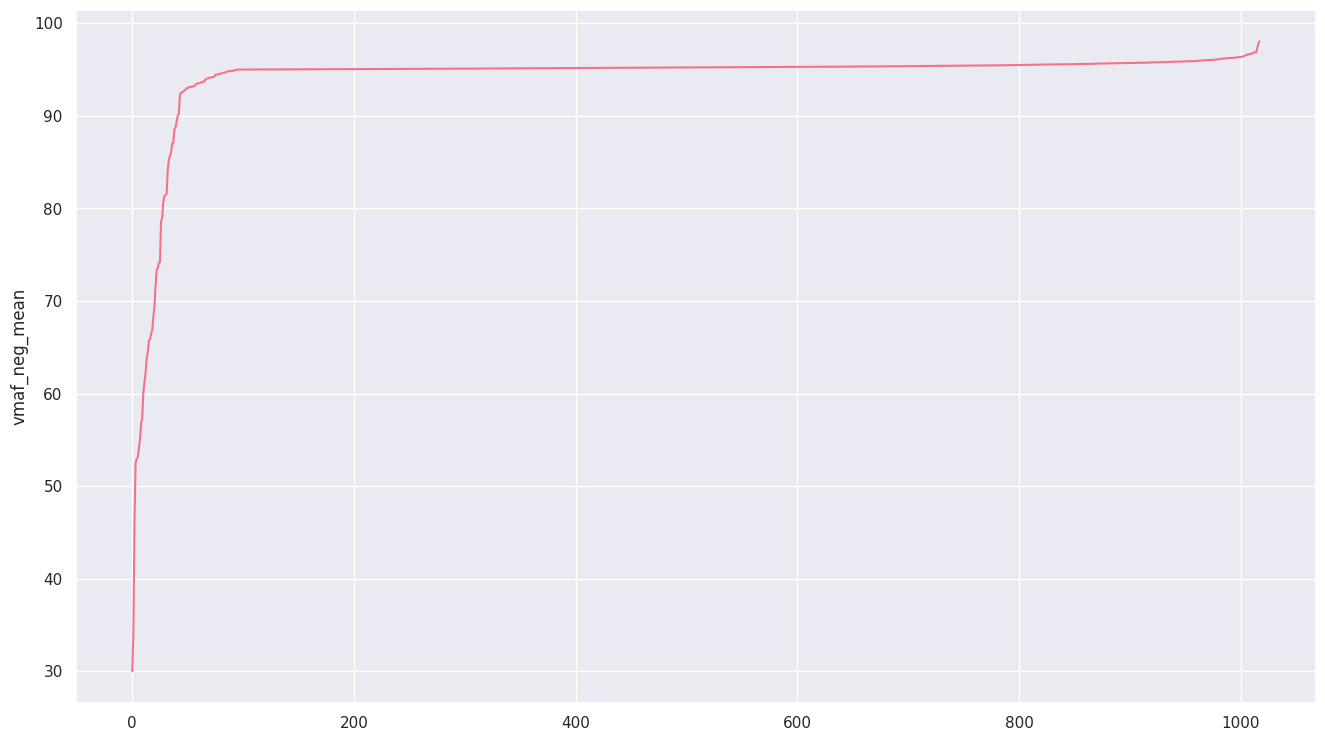

In [7]:
sns.lineplot(target_dataset_df['vmaf_neg_mean'].sort_values().reset_index(drop=True))

In [44]:
feature_df = pd.read_csv('https://storage.yandexcloud.net/tnn-datasets/big_features.csv')

In [9]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 95 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    980 non-null    int64  
 1   name_                         980 non-null    object 
 2   width_min                     980 non-null    int64  
 3   height_min                    980 non-null    int64  
 4   format_first                  980 non-null    object 
 5   CTI_std_min                   980 non-null    float64
 6   CTI_std_mean                  980 non-null    float64
 7   CTI_std_median                980 non-null    float64
 8   CTI_std_max                   980 non-null    float64
 9   CTI_std_std                   980 non-null    float64
 10  SI_std_min                    980 non-null    float64
 11  SI_std_mean                   980 non-null    float64
 12  SI_std_median                 980 non-null    float64
 13  SI_st

In [45]:
feature_df.sample(10)

,Unnamed: 0,name_,width_min,height_min,format_first,CTI_std_min,CTI_std_mean,CTI_std_median,CTI_std_max,CTI_std_std,...,CI_V_mean_min,CI_V_mean_mean,CI_V_mean_median,CI_V_mean_max,CI_V_mean_std,FHV13_min,FHV13_mean,FHV13_median,FHV13_max,FHV13_std
33,33,Animation_480P-073c,640,480,yuv420p,35.425010,36.301503,36.201967,37.429142,0.343598,...,127.051146,129.869487,128.040365,139.035983,3.596296,16.895833,17.926332,17.593750,20.302083,0.920763
751,751,Sports_480P-5f38,360,640,yuv420p,33.795654,34.886176,34.992616,36.315016,0.613637,...,153.101853,162.756475,164.178663,173.069102,5.037349,28.312500,30.363472,30.468750,31.708333,0.707012
145,145,Gaming_1080P-1704,1920,1080,yuv420p,31.553171,36.015804,35.818324,38.735718,1.127529,...,116.840673,130.355056,131.366689,141.034401,4.193034,32.187500,33.975069,33.916667,38.500000,0.959116
465,465,LyricVideo_1080P-584f,1920,1080,yuv420p,28.325127,31.995533,31.595839,33.416699,1.345825,...,187.344653,193.663832,188.893915,200.176241,5.490941,32.083333,33.178958,33.072917,34.083333,0.801739
943,943,Vlog_360P-4795,640,360,yuv420p,30.114552,50.861792,51.277583,69.513463,8.424727,...,89.263086,157.417388,159.246413,232.164753,30.797448,19.187500,35.657083,36.541667,44.375000,4.308737
309,309,HowTo_720P-269e,1280,720,yuv420p,53.265250,58.880154,62.030727,63.283071,4.281905,...,79.513548,90.610394,97.815526,98.861526,8.670270,1.717448,10.031634,15.062500,16.666667,6.490317
746,746,Sports_480P-41a5,854,480,yuv420p,46.447808,58.538528,58.017809,67.786927,4.206358,...,139.012273,172.367276,175.618616,188.979806,7.684868,26.812500,29.013250,28.937500,34.479167,1.022234
824,824,TelevisionClip_720P-1862,1280,720,yuv420p,34.784960,37.534528,38.265593,39.816670,1.878525,...,120.869494,134.701836,134.750915,143.232414,4.909200,23.395833,25.351210,25.312500,28.395833,1.597800
907,907,Vlog_1080P-5904,1920,1080,yuv420p,17.701227,47.384938,47.815952,61.556110,8.041337,...,136.570583,188.403023,185.561630,256.036138,22.255620,21.062500,33.994800,34.302083,38.166667,2.342535
544,544,MusicVideo_480P-6fb6,640,480,yuv420p,45.991543,47.468424,47.092355,49.598009,0.963132,...,93.999997,95.764676,95.173540,98.581911,1.285861,1.016927,1.533723,1.264323,3.588542,0.508787


In [46]:
feature_df['source_name'] = feature_df['name_']
feature_df = feature_df.drop(columns=['Unnamed: 0', 'name_'], errors='ignore')
feature_df.head()

,width_min,height_min,format_first,CTI_std_min,CTI_std_mean,CTI_std_median,CTI_std_max,CTI_std_std,SI_std_min,SI_std_mean,...,CI_V_mean_mean,CI_V_mean_median,CI_V_mean_max,CI_V_mean_std,FHV13_min,FHV13_mean,FHV13_median,FHV13_max,FHV13_std,source_name
0,1920,1080,yuv420p,44.182550,52.156226,52.109668,60.752072,2.904819,14.939627,59.474814,...,151.482895,123.352363,207.739868,49.339612,1.000000,22.533888,18.947917,36.895833,11.117238,Animation_1080P-05f8
1,1920,1080,yuv420p,42.300637,45.980305,46.295275,51.364939,2.045704,80.178947,100.609806,...,258.492611,258.702112,271.874362,5.855529,15.468750,21.280859,22.937500,26.333333,3.319351,Animation_1080P-0c4f
2,1920,1080,yuv420p,55.678482,60.176203,60.409364,66.221454,2.808085,64.997353,90.555054,...,217.636896,223.705146,230.810561,13.477754,26.145833,28.073664,28.229167,30.291667,0.995820,Animation_1080P-18f5
3,1920,1080,yuv420p,41.429365,43.924084,42.412440,48.773801,2.854323,63.522049,72.807659,...,241.594533,234.606746,262.734905,11.253415,25.208333,26.286500,26.541667,26.937500,0.559128,Animation_1080P-209f
4,1920,1080,yuv420p,53.492048,54.621218,54.238353,56.642177,0.974844,41.466827,62.484905,...,92.114836,91.311481,98.091593,3.162987,22.437500,23.858429,23.895833,26.375000,0.628671,Animation_1080P-21dd


In [52]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 94 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   width_min                     980 non-null    int64  
 1   height_min                    980 non-null    int64  
 2   format_first                  980 non-null    object 
 3   CTI_std_min                   980 non-null    float64
 4   CTI_std_mean                  980 non-null    float64
 5   CTI_std_median                980 non-null    float64
 6   CTI_std_max                   980 non-null    float64
 7   CTI_std_std                   980 non-null    float64
 8   SI_std_min                    980 non-null    float64
 9   SI_std_mean                   980 non-null    float64
 10  SI_std_median                 980 non-null    float64
 11  SI_std_max                    980 non-null    float64
 12  SI_std_std                    980 non-null    float64
 13  TI_st

In [12]:
learning_dataset = feature_df.merge(target_dataset_df[['source_name', 'parameter', 'value']], how='inner', left_on='source_name', right_on='source_name')

In [13]:
learning_dataset

,width_min,height_min,format_first,CTI_std_min,CTI_std_mean,CTI_std_median,CTI_std_max,CTI_std_std,SI_std_min,SI_std_mean,...,CI_V_mean_max,CI_V_mean_std,FHV13_min,FHV13_mean,FHV13_median,FHV13_max,FHV13_std,source_name,parameter,value
0,1920,1080,yuv420p,44.182550,52.156226,52.109668,60.752072,2.904819,14.939627,59.474814,...,207.739868,49.339612,1.000000,22.533888,18.947917,36.895833,11.117238,Animation_1080P-05f8,crf,22
1,1920,1080,yuv420p,42.300637,45.980305,46.295275,51.364939,2.045704,80.178947,100.609806,...,271.874362,5.855529,15.468750,21.280859,22.937500,26.333333,3.319351,Animation_1080P-0c4f,crf,22
2,1920,1080,yuv420p,55.678482,60.176203,60.409364,66.221454,2.808085,64.997353,90.555054,...,230.810561,13.477754,26.145833,28.073664,28.229167,30.291667,0.995820,Animation_1080P-18f5,crf,20
3,1920,1080,yuv420p,41.429365,43.924084,42.412440,48.773801,2.854323,63.522049,72.807659,...,262.734905,11.253415,25.208333,26.286500,26.541667,26.937500,0.559128,Animation_1080P-209f,qp,26
4,1920,1080,yuv420p,53.492048,54.621218,54.238353,56.642177,0.974844,41.466827,62.484905,...,98.091593,3.162987,22.437500,23.858429,23.895833,26.375000,0.628671,Animation_1080P-21dd,qp,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1280,720,yuv420p,59.945031,63.419143,63.905179,65.593744,1.471084,51.124294,67.979152,...,228.691708,2.728591,23.270833,25.090180,24.854167,27.229167,0.896256,Vlog_720P-3e9c,crf,23
976,1280,720,yuv420p,42.233801,53.955423,54.909413,62.063753,4.164083,39.386581,94.381622,...,217.024146,9.194265,25.916667,29.617326,29.229167,35.145833,1.453339,Vlog_720P-4e3d,crf,30
977,1280,720,yuv420p,20.590320,39.452944,41.478989,73.587980,9.846750,4.397942,21.184699,...,261.149613,47.577228,20.375000,37.351736,36.729167,52.208333,4.608039,Vlog_720P-5364,crf,19
978,1280,720,yuv420p,35.030290,41.984969,40.648420,50.228325,3.578561,16.094381,63.833336,...,237.639770,9.958203,28.541667,32.693637,33.041667,39.500000,1.798026,Vlog_720P-60f8,crf,30


In [14]:
learning_dataset.drop(columns=['format_first'], inplace=True)

In [15]:
learning_dataset

,width_min,height_min,CTI_std_min,CTI_std_mean,CTI_std_median,CTI_std_max,CTI_std_std,SI_std_min,SI_std_mean,SI_std_median,...,CI_V_mean_max,CI_V_mean_std,FHV13_min,FHV13_mean,FHV13_median,FHV13_max,FHV13_std,source_name,parameter,value
0,1920,1080,44.182550,52.156226,52.109668,60.752072,2.904819,14.939627,59.474814,23.798477,...,207.739868,49.339612,1.000000,22.533888,18.947917,36.895833,11.117238,Animation_1080P-05f8,crf,22
1,1920,1080,42.300637,45.980305,46.295275,51.364939,2.045704,80.178947,100.609806,100.571869,...,271.874362,5.855529,15.468750,21.280859,22.937500,26.333333,3.319351,Animation_1080P-0c4f,crf,22
2,1920,1080,55.678482,60.176203,60.409364,66.221454,2.808085,64.997353,90.555054,93.860611,...,230.810561,13.477754,26.145833,28.073664,28.229167,30.291667,0.995820,Animation_1080P-18f5,crf,20
3,1920,1080,41.429365,43.924084,42.412440,48.773801,2.854323,63.522049,72.807659,70.479279,...,262.734905,11.253415,25.208333,26.286500,26.541667,26.937500,0.559128,Animation_1080P-209f,qp,26
4,1920,1080,53.492048,54.621218,54.238353,56.642177,0.974844,41.466827,62.484905,65.252586,...,98.091593,3.162987,22.437500,23.858429,23.895833,26.375000,0.628671,Animation_1080P-21dd,qp,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1280,720,59.945031,63.419143,63.905179,65.593744,1.471084,51.124294,67.979152,67.281845,...,228.691708,2.728591,23.270833,25.090180,24.854167,27.229167,0.896256,Vlog_720P-3e9c,crf,23
976,1280,720,42.233801,53.955423,54.909413,62.063753,4.164083,39.386581,94.381622,99.579712,...,217.024146,9.194265,25.916667,29.617326,29.229167,35.145833,1.453339,Vlog_720P-4e3d,crf,30
977,1280,720,20.590320,39.452944,41.478989,73.587980,9.846750,4.397942,21.184699,18.031554,...,261.149613,47.577228,20.375000,37.351736,36.729167,52.208333,4.608039,Vlog_720P-5364,crf,19
978,1280,720,35.030290,41.984969,40.648420,50.228325,3.578561,16.094381,63.833336,68.012665,...,237.639770,9.958203,28.541667,32.693637,33.041667,39.500000,1.798026,Vlog_720P-60f8,crf,30


In [16]:
learning_dataset.to_csv('learning.csv')

<Axes: xlabel='value', ylabel='0'>

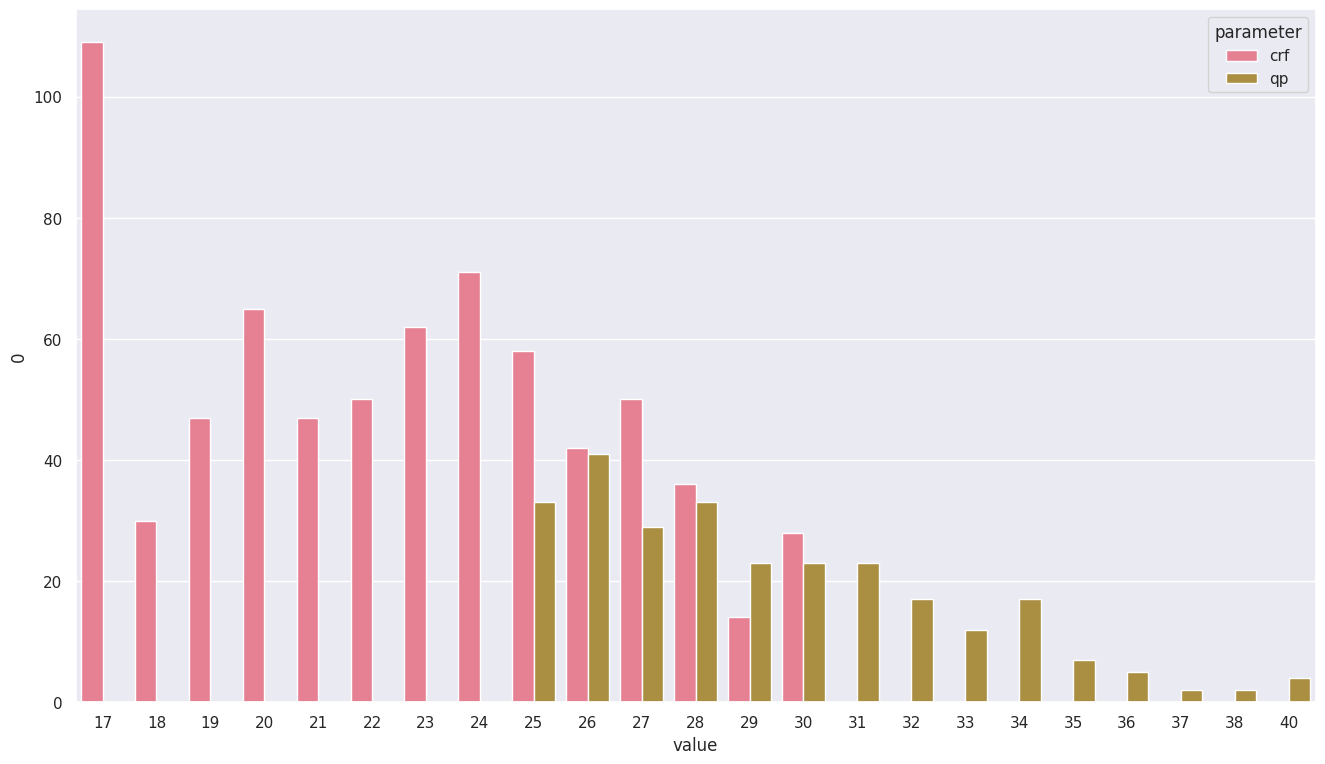

: 

In [ ]:
sns.barplot(learning_dataset.groupby(['parameter', 'value']).size().reset_index(), x='value', y=0, hue='parameter')

In [26]:
analyzed_encoded_packets_df.to_csv('bitrate_per_packet.csv.gz', compression='gzip')

In [27]:
s3_client.upload_file('bitrate_per_packet.csv.gz', Bucket='tnn-datasets', Key='bitrate_per_packet.csv.gz')

In [ ]:
analyzed_encoded_packets_df = pd.read_csv('bitrate_per_packet.csv.gz')

In [10]:
analyzed_encoded_packets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18323118 entries, 0 to 18323117
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   stream_index   int64  
 2   pts            int64  
 3   pts_time       float64
 4   duration       int64  
 5   duration_time  float64
 6   size           int64  
 7   pos            int64  
 8   flags          object 
 9   source_name    object 
 10  parameter      object 
 11  value          int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1.6+ GB


In [6]:
qualities_df = pd.read_csv('https://storage.yandexcloud.net/tnn-datasets/qualities.csv.gz')
qualities_df.head()

,Unnamed: 0,Frame,integer_motion2,integer_motion,integer_vif_scale0_egl_1,integer_vif_scale1_egl_1,integer_vif_scale2_egl_1,integer_vif_scale3_egl_1,integer_adm2_egl_1,integer_adm_scale0_egl_1,integer_adm_scale1_egl_1,integer_adm_scale2_egl_1,integer_adm_scale3_egl_1,vmaf_neg,path,name,source_name,parameter,value
0,0,0,0.000000,0.000000,0.955222,0.996344,0.997383,0.997656,0.991308,0.989319,0.986076,0.991938,0.995016,95.191619,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
1,1,1,1.410804,1.411460,0.902246,0.991513,0.994908,0.996049,0.983458,0.978583,0.974455,0.986450,0.989370,95.117126,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
2,2,2,1.410804,1.410804,0.912168,0.992003,0.995274,0.996386,0.985633,0.981161,0.977881,0.987248,0.991799,95.641271,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
3,3,3,1.421855,1.443692,0.903478,0.991283,0.994581,0.996172,0.984039,0.978358,0.976758,0.985778,0.990883,95.253092,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
4,4,4,1.421855,1.421855,0.915657,0.992493,0.995477,0.996319,0.985796,0.981812,0.979226,0.987693,0.991029,95.699500,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17


In [12]:
short_qualities_df = qualities_df[['Frame', 'vmaf_neg', 'name', 'source_name', 'parameter', 'value']]

In [13]:
short_qualities_df.sort_values(['source_name', 'parameter', 'value', 'Frame'], inplace=True)

/var/tmp/ipykernel_1637145/3897159643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_qualities_df.sort_values(['source_name', 'parameter', 'value', 'Frame'], inplace=True)


In [14]:
short_qualities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18289725 entries, 0 to 18289724
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Frame        int64  
 1   vmaf_neg     float64
 2   name         object 
 3   source_name  object 
 4   parameter    object 
 5   value        int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 837.2+ MB


In [15]:
analyzed_encoded_packets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18323118 entries, 0 to 18323117
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   stream_index   int64  
 2   pts            int64  
 3   pts_time       float64
 4   duration       int64  
 5   duration_time  float64
 6   size           int64  
 7   pos            int64  
 8   flags          object 
 9   source_name    object 
 10  parameter      object 
 11  value          int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1.6+ GB


In [15]:
bitrate_df = pd.read_csv('bitrate.csv.gz')
bitrate_df

,duration_encoded,bit_rate_encoded,size_encoded,source_name,parameter,value,duration_source,bit_rate_source,size_source
0,19.960000,16266563,40593806,Animation_1080P-05f8,crf,17,19.960000,622090913,1552116828
1,19.960000,14138555,35284346,Animation_1080P-05f8,crf,18,19.960000,622090913,1552116828
2,19.960000,12214888,30484729,Animation_1080P-05f8,crf,19,19.960000,622090913,1552116828
3,19.960000,10485608,26170157,Animation_1080P-05f8,crf,20,19.960000,622090913,1552116828
4,19.960000,8997804,22458050,Animation_1080P-05f8,crf,21,19.960000,622090913,1552116828
...,...,...,...,...,...,...,...,...,...
30048,19.986633,865778,2173102,Vlog_720P-6d56,qp,36,19.986634,331457333,828089552
30049,19.986633,722064,1814043,Vlog_720P-6d56,qp,37,19.986634,331457333,828089552
30050,19.986633,607407,1527592,Vlog_720P-6d56,qp,38,19.986634,331457333,828089552
30051,19.986633,514341,1295082,Vlog_720P-6d56,qp,39,19.986634,331457333,828089552


<Axes: xlabel='duration_source', ylabel='Count'>

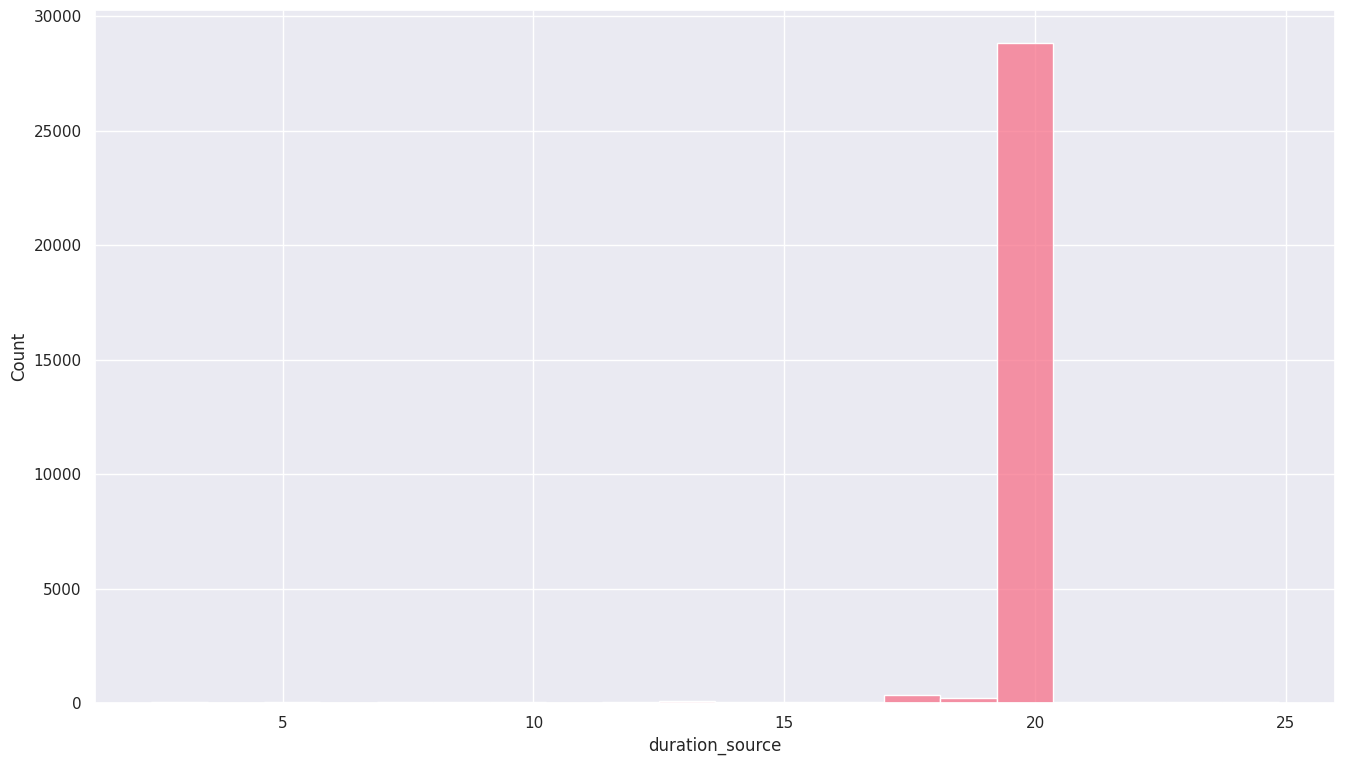

In [28]:
sns.histplot(bitrate_df['duration_source'], bins=20)

In [25]:
bitrate_df[bitrate_df['duration_source']<15]

,duration_encoded,bit_rate_encoded,size_encoded,source_name,parameter,value,duration_source,bit_rate_source,size_source
994,13.558223,1188552,2019874,Animation_480P-087e,crf,17,13.558223,63935852,108357068
995,13.558223,1076017,1829135,Animation_480P-087e,crf,18,13.558223,63935852,108357068
996,13.558223,977986,1663011,Animation_480P-087e,crf,19,13.558223,63935852,108357068
997,13.558223,890583,1514882,Animation_480P-087e,crf,20,13.558223,63935852,108357068
998,13.558223,806357,1372137,Animation_480P-087e,crf,21,13.558223,63935852,108357068
...,...,...,...,...,...,...,...,...,...
29420,3.003000,179982,71484,Vlog_480P-5e1c,qp,36,3.003000,7367888,2765721
29421,3.003000,164904,65840,Vlog_480P-5e1c,qp,37,3.003000,7367888,2765721
29422,3.003000,148646,59721,Vlog_480P-5e1c,qp,38,3.003000,7367888,2765721
29423,3.003000,135520,54794,Vlog_480P-5e1c,qp,39,3.003000,7367888,2765721


In [29]:
bitrate_df.describe()

,duration_encoded,bit_rate_encoded,size_encoded,value,duration_source,bit_rate_source,size_source
count,30053.000000,3.005300e+04,3.005300e+04,30053.000000,30053.000000,3.005300e+04,3.005300e+04
mean,19.839727,5.858181e+06,1.450270e+07,28.317007,19.841039,7.394407e+08,1.827880e+09
std,1.281324,1.363523e+07,3.375920e+07,6.253100,1.276234,1.617164e+09,4.025114e+09
min,2.382009,4.697000e+03,1.278900e+04,17.000000,2.382009,7.248513e+06,2.765721e+06
25%,19.983051,4.499370e+05,1.120695e+06,24.000000,19.983334,1.075263e+08,2.663732e+08
50%,20.000000,1.502377e+06,3.726846e+06,28.000000,20.000000,2.764907e+08,6.912268e+08
75%,20.000000,5.179511e+06,1.281582e+07,33.000000,20.000000,6.635774e+08,1.657561e+09
max,24.856803,2.661551e+08,6.649715e+08,40.000000,24.856804,1.590937e+10,3.978001e+10


<Axes: xlabel='bit_rate_encoded', ylabel='Count'>

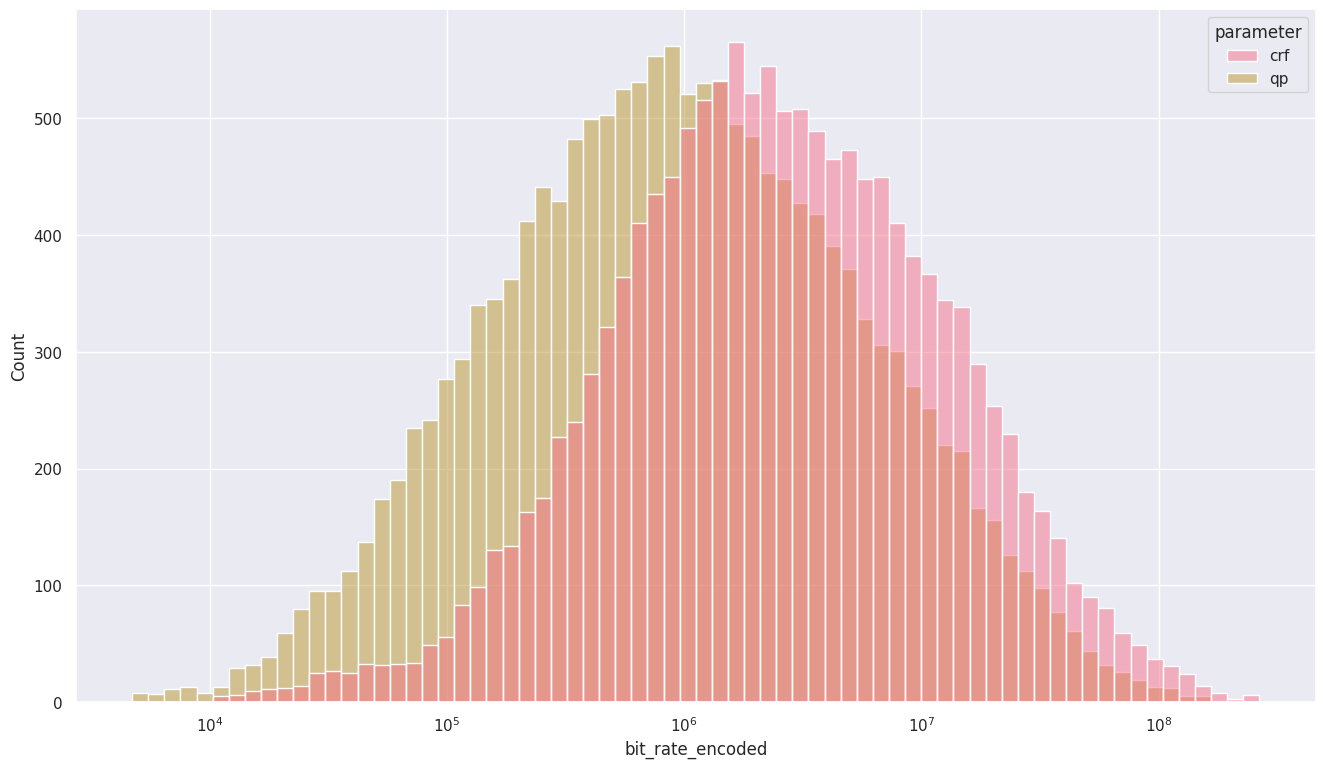

In [32]:
sns.histplot(bitrate_df, x='bit_rate_encoded', hue='parameter', log_scale=True)

In [33]:
qualities_df.head()

,Unnamed: 0,Frame,integer_motion2,integer_motion,integer_vif_scale0_egl_1,integer_vif_scale1_egl_1,integer_vif_scale2_egl_1,integer_vif_scale3_egl_1,integer_adm2_egl_1,integer_adm_scale0_egl_1,integer_adm_scale1_egl_1,integer_adm_scale2_egl_1,integer_adm_scale3_egl_1,vmaf_neg,path,name,source_name,parameter,value
0,0,0,0.000000,0.000000,0.955222,0.996344,0.997383,0.997656,0.991308,0.989319,0.986076,0.991938,0.995016,95.191619,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
1,1,1,1.410804,1.411460,0.902246,0.991513,0.994908,0.996049,0.983458,0.978583,0.974455,0.986450,0.989370,95.117126,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
2,2,2,1.410804,1.410804,0.912168,0.992003,0.995274,0.996386,0.985633,0.981161,0.977881,0.987248,0.991799,95.641271,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
3,3,3,1.421855,1.443692,0.903478,0.991283,0.994581,0.996172,0.984039,0.978358,0.976758,0.985778,0.990883,95.253092,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17
4,4,4,1.421855,1.421855,0.915657,0.992493,0.995477,0.996319,0.985796,0.981812,0.979226,0.987693,0.991029,95.699500,Animation/1080P/Animation_1080P-05f8_crf_17.mk...,Animation_1080P-05f8_crf_17,Animation_1080P-05f8,crf,17


In [42]:
quality_bitrate_df[['source_name', 'parameter', 'value', 'vmaf_neg_mean']]

,source_name,parameter,value,vmaf_neg_mean
0,Animation_1080P-05f8,crf,17,97.627268
1,Animation_1080P-05f8,crf,18,97.482780
2,Animation_1080P-05f8,crf,19,97.321157
3,Animation_1080P-05f8,crf,20,97.130756
4,Animation_1080P-05f8,crf,21,96.902823
...,...,...,...,...
29995,Vlog_720P-6d56,qp,36,81.794359
29996,Vlog_720P-6d56,qp,37,78.906290
29997,Vlog_720P-6d56,qp,38,75.671001
29998,Vlog_720P-6d56,qp,39,72.508412


In [49]:
learning_dataset = feature_df.merge(quality_bitrate_df[['source_name', 'parameter', 'value', 'vmaf_neg_mean']], how='inner', left_on='source_name', right_on='source_name')

In [54]:
learning_dataset.drop(columns=['source_name']).to_csv('target_dataset2.csv.gz', index=False, compression='gzip')

In [61]:
only_features = feature_df.drop(columns=['format_first', 'width_min', 'height_min', 'source_name'])

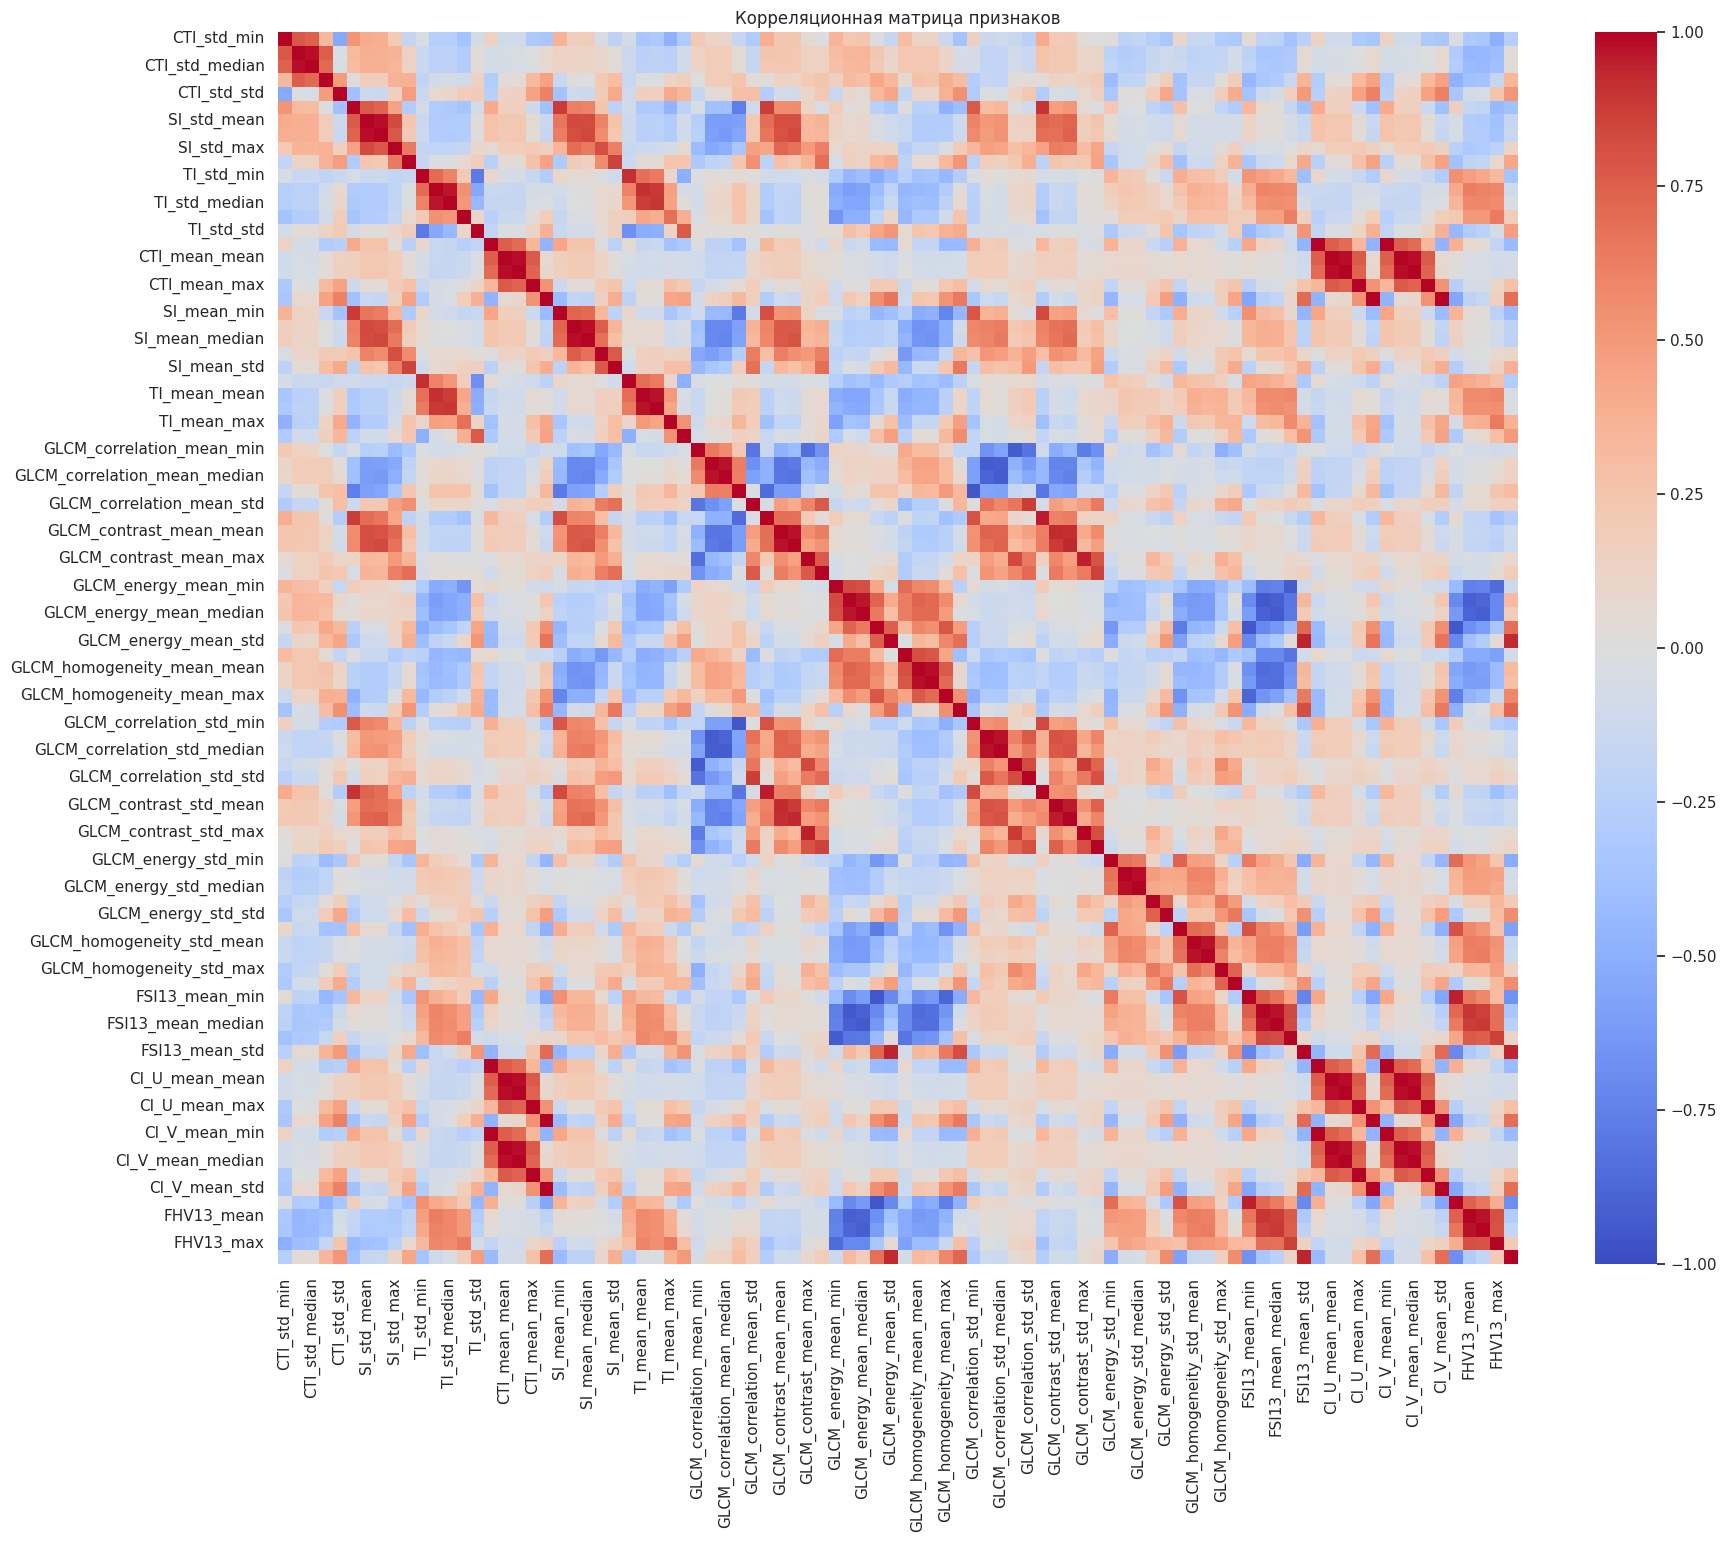

In [62]:
import numpy as np
# Предполагая, что ваш датафрейм называется df
# Выбираем только числовые столбцы для анализа корреляции
numeric_df = only_features.select_dtypes(include=[np.number])

# Построение корреляционной матрицы
corr_matrix = numeric_df.corr()

# Визуализация корреляционной матрицы (можно сделать для подматрицы, если признаков слишком много)
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица признаков')
plt.show()

In [63]:
only_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CTI_std_min                   980 non-null    float64
 1   CTI_std_mean                  980 non-null    float64
 2   CTI_std_median                980 non-null    float64
 3   CTI_std_max                   980 non-null    float64
 4   CTI_std_std                   980 non-null    float64
 5   SI_std_min                    980 non-null    float64
 6   SI_std_mean                   980 non-null    float64
 7   SI_std_median                 980 non-null    float64
 8   SI_std_max                    980 non-null    float64
 9   SI_std_std                    980 non-null    float64
 10  TI_std_min                    980 non-null    float64
 11  TI_std_mean                   980 non-null    float64
 12  TI_std_median                 980 non-null    float64
 13  TI_st

In [64]:
def remove_highly_correlated_features(df, threshold=0.9, exclude_columns=[]):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()

    # Верхний треугольник корреляционной матрицы
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Находим признаки с корреляцией выше порога
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Количество признаков для удаления: {len(to_drop)}")
    print(f"Признаки для удаления: {to_drop}")

    return df.drop(to_drop, axis=1)

In [67]:
reduced_features = remove_highly_correlated_features(only_features, threshold=0.9)
print(f"Осталось признаков: {reduced_features.shape[1]} из {only_features.shape[1]}")

Количество признаков для удаления: 41
Признаки для удаления: ['CTI_std_median', 'SI_std_median', 'TI_std_median', 'CTI_mean_median', 'SI_mean_median', 'TI_mean_min', 'TI_mean_mean', 'TI_mean_median', 'GLCM_correlation_mean_median', 'GLCM_contrast_mean_median', 'GLCM_energy_mean_median', 'GLCM_homogeneity_mean_median', 'GLCM_correlation_std_min', 'GLCM_correlation_std_mean', 'GLCM_correlation_std_median', 'GLCM_correlation_std_max', 'GLCM_contrast_std_min', 'GLCM_contrast_std_mean', 'GLCM_contrast_std_median', 'GLCM_contrast_std_max', 'GLCM_energy_std_median', 'GLCM_homogeneity_std_median', 'FSI13_mean_min', 'FSI13_mean_mean', 'FSI13_mean_median', 'FSI13_mean_max', 'FSI13_mean_std', 'CI_U_mean_min', 'CI_U_mean_mean', 'CI_U_mean_median', 'CI_U_mean_max', 'CI_U_mean_std', 'CI_V_mean_min', 'CI_V_mean_mean', 'CI_V_mean_median', 'CI_V_mean_max', 'CI_V_mean_std', 'FHV13_min', 'FHV13_mean', 'FHV13_median', 'FHV13_std']
Осталось признаков: 49 из 90


In [72]:
learning_dataset = feature_df[['source_name', 'width_min', 'height_min'] + list(reduced_features.columns)].merge(
    quality_bitrate_df[['source_name', 'parameter', 'value', 'vmaf_neg_mean']], how='inner', left_on='source_name', right_on='source_name'
)

In [73]:
learning_dataset.drop(columns=['source_name']).to_csv('target_dataset3.csv.gz', index=False, compression='gzip')

In [74]:
s3_client.upload_file('target_dataset3.csv.gz', Bucket='tnn-datasets', Key='target_dataset3.csv.gz')

In [6]:
learning_dataset = pd.read_csv('target_dataset3.csv.gz')

In [11]:
learning_dataset.groupby(['parameter', 'value']).agg({'vmaf_neg_mean': ['mean', 'min', 'max', 'median']}).reset_index()

parameter value vmaf_neg_mean                                 
                            mean        min        max     median
0        crf    17     96.703648  29.984344  99.995388  97.499888
1        crf    18     96.491886  29.921440  99.995069  97.201671
2        crf    19     96.137064  29.844838  99.994250  96.907998
3        crf    20     95.865702  29.759837  99.993498  96.609770
4        crf    21     95.507354  29.661837  99.993310  96.288986
5        crf    22     95.046804  29.543439  99.993172  95.876940
6        crf    23     94.511123  29.392670  99.992890  95.453276
7        crf    24     93.928139  29.224191  99.991782  94.969926
8        crf    25     93.260102  29.012217  99.990837  94.357740
9        crf    26     92.447777  28.784143  99.990441  93.625013
10       crf    27     91.447936  13.664988  99.989695  92.817444
11       crf    28     90.542430  28.156126  99.989006  91.899245
12       crf    29     89.388797  27.767950  99.988245  90.821863
13       crf    30     88.058811  27.326259  99.987444  89.426230
14        qp    25     94.909498  33.702525  99.993765  95.489970
15        qp    26     94.269430  29.534212  99.993263  94.953430
16        qp    27     93.610078  29.365952  99.992711  94.301048
17        qp    28     92.938471  29.167628  99.992075  93.611574
18        qp    29     92.001642  28.916143  99.991297  92.672331
19        qp    30     91.041582  28.632119  99.989361  91.736045
20        qp    31     89.858811  28.290946  99.989457  90.471855
21        qp    32     88.528309  27.869846  99.987794  89.099599
22        qp    33     86.989412  27.412934  99.986632  87.528733
23        qp    34     85.364128  26.882548  99.985863  85.888834
24        qp    35     83.381098  26.287432  99.984785  83.825996
25        qp    36     81.226520  25.621464  99.972684  81.751378
26        qp    37     78.866660  24.884616  99.889320  79.399739
27        qp    38     76.323049  23.991846  99.479544  76.679299
28        qp    39     73.609947  23.076008  98.781975  74.092505
29        qp    40     70.668704  22.139270  97.836869  71.058318

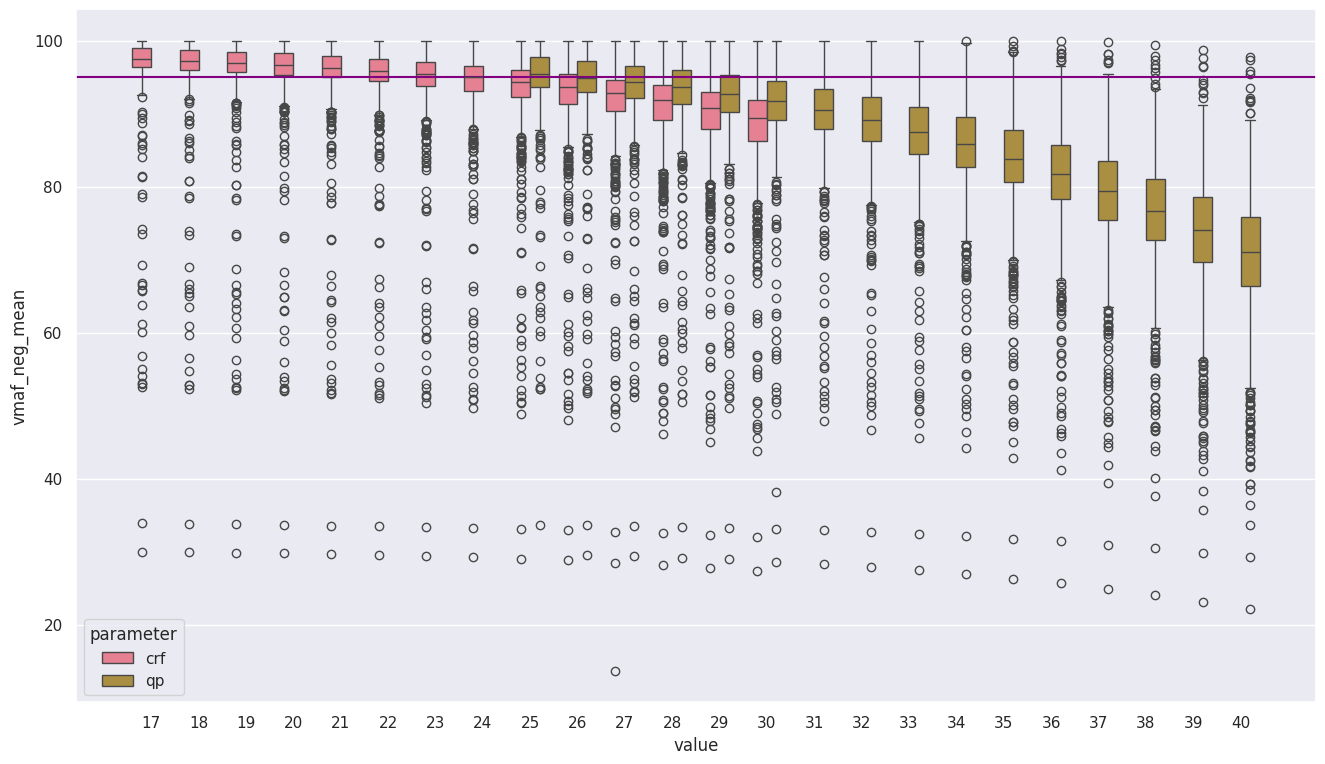

In [14]:
plot = sns.boxplot(learning_dataset[['parameter', 'value', 'vmaf_neg_mean']], x='value', hue='parameter', y='vmaf_neg_mean')
plot.axline((0, 95), slope=0, color='purple')

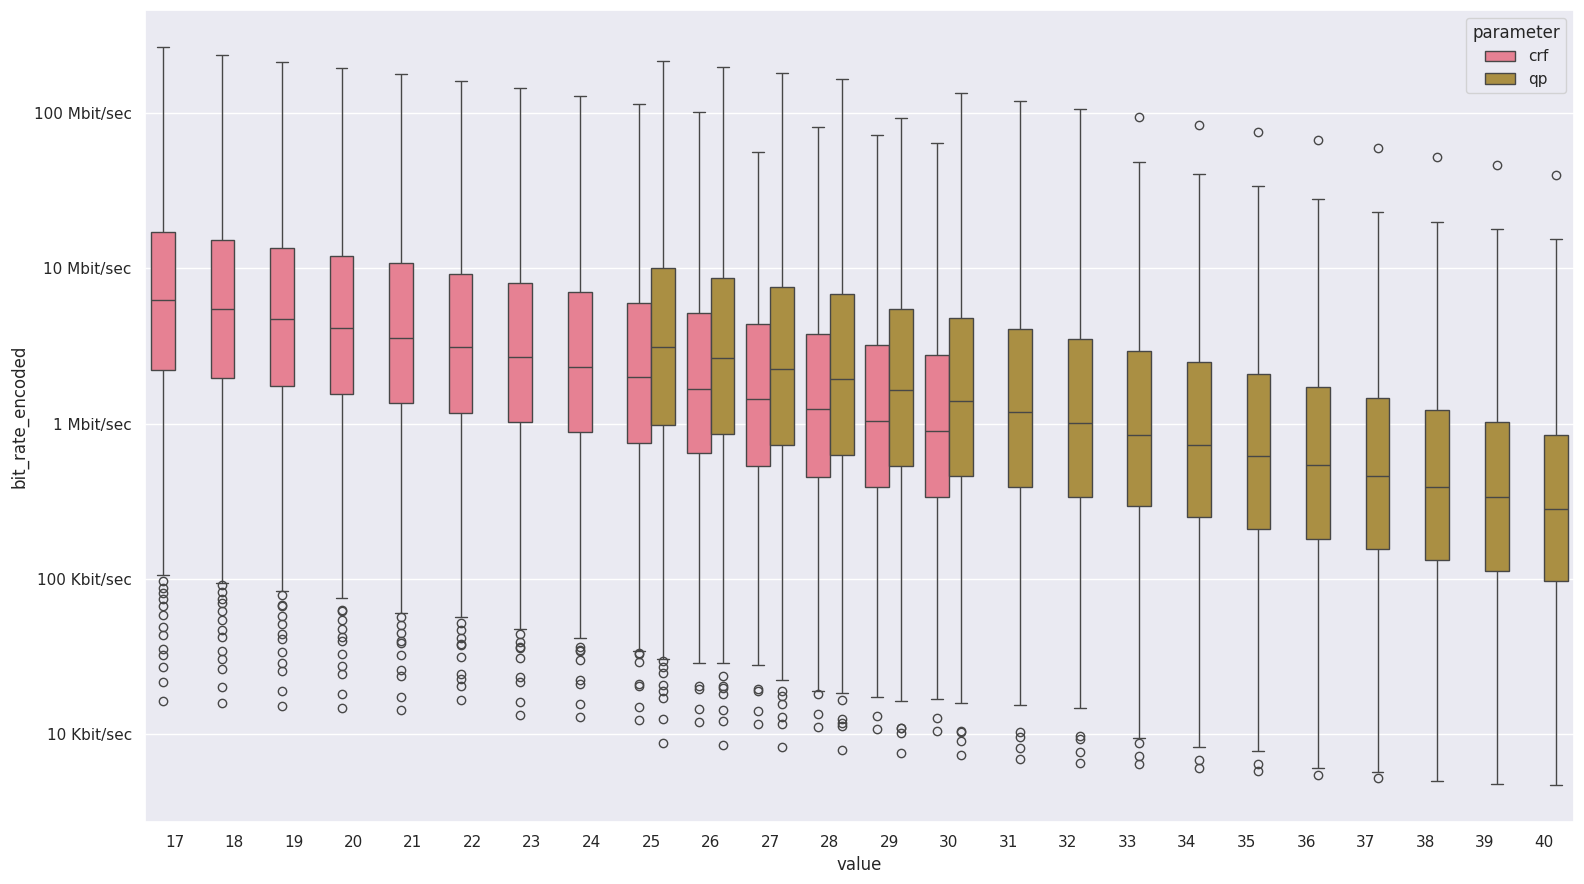

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

plot = sns.boxplot(bitrate_df[['parameter', 'value', 'bit_rate_encoded']], x='value', hue='parameter', y='bit_rate_encoded', log_scale=True)

def format_bitrate(x, pos):
    prefix = ['', 'K', 'M', 'G', 'T']
    i = 0
    scale = 10**3
    i = int(math.log(x, scale))
    x /= scale ** i
    return f'{x:.0f} {prefix[i]}bit/sec'

y_formatter = ticker.FuncFormatter(format_bitrate)
plot.yaxis.set_major_formatter(y_formatter)
plt.tight_layout()